<a href="https://colab.research.google.com/github/Saibhossain/lungCancer_survival_model_analysis/blob/main/radiomics_features_422_with_(VIF).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# setup

In [2]:
!pip install tqdm scikit-learn
!pip install torchio
!pip install numpy
!pip install lifelines
!pip install SimpleITK
!pip install shap
!pip install pycox torchtuples seaborn
!pip install rt-utils scikit-survival

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.9/193.9 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 17.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 9.7 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=ccc17b50aaee59fdffc11dd4d6767ca67ca2ed72306988bc6262d07e550faed6
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 k

# code for survival model

## CoxPH radiomics_features_422 with (VIF)

 Merged dataset: 422 patients
➡️ Final: 422 patients, 214 features

🔎 Removing multicollinearity (VIF) on training data...


Reducing Multicollinearity (VIF): 0feat [00:00, ?feat/s]

 Dropped due to VIF > 5.0 : ['original_firstorder_Maximum_seg', 'original_glcm_JointAverage_seg', 'original_firstorder_Maximum_rtstruct', 'original_glcm_JointAverage_rtstruct', 'original_glszm_ZoneVariance_rtstruct', 'original_glcm_SumSquares_seg', 'original_glcm_SumSquares_rtstruct', 'original_glszm_LargeAreaEmphasis_seg', 'original_glcm_Id_rtstruct', 'original_shape_VoxelVolume_seg', 'original_shape_VoxelVolume_rtstruct', 'original_glrlm_ShortRunEmphasis_rtstruct', 'original_glrlm_LongRunEmphasis_rtstruct', 'original_firstorder_Energy_seg', 'original_glrlm_LowGrayLevelRunEmphasis_rtstruct', 'original_gldm_GrayLevelVariance_rtstruct', 'original_firstorder_Entropy_rtstruct', 'original_gldm_GrayLevelNonUniformity_rtstruct', 'original_glrlm_RunPercentage_rtstruct', 'original_glcm_Idm_seg', 'original_gldm_HighGrayLevelEmphasis_rtstruct', 'original_shape_MeshVolume_rtstruct', 'original_firstorder_Variance_seg', 'original_glrlm_HighGrayLevelRunEmphasis_rtstruct', 'original_firstorder_Unifor

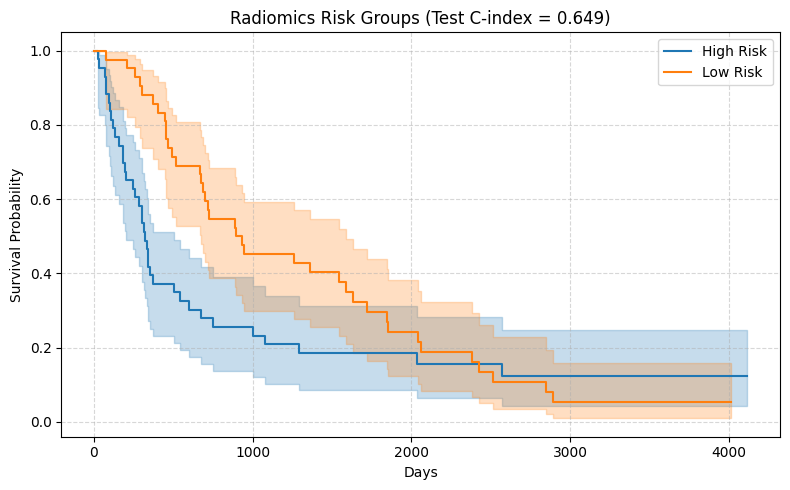


 Log-rank Test: p = 0.0472

 Computing SHAP values (exact linear SHAP + optional Kernel SHAP verification)...

 Top features by mean |linear SHAP|:
original_ngtdm_Busyness_seg                                0.013911
original_shape_MajorAxisLength_seg                         0.012592
original_gldm_DependenceVariance_seg                       0.011954
original_firstorder_Minimum_seg                            0.010706
original_firstorder_InterquartileRange_rtstruct            0.008593
original_firstorder_TotalEnergy_seg                        0.008359
original_shape_Sphericity_seg                              0.008233
original_glszm_SizeZoneNonUniformityNormalized_rtstruct    0.006815
original_firstorder_Kurtosis_seg                           0.006188
original_glcm_Imc1_seg                                     0.005496
dtype: float64


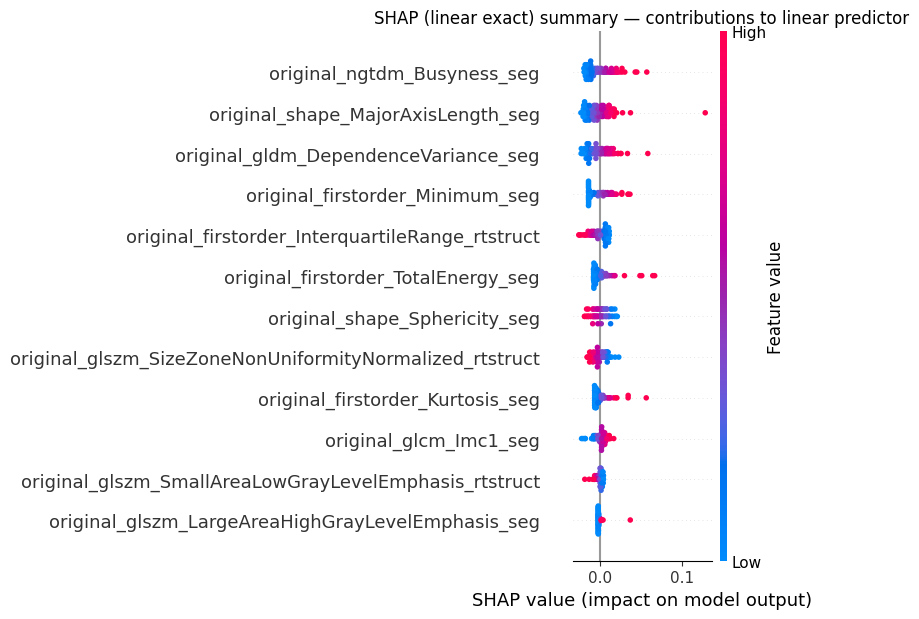


Running Kernel SHAP on a small subset (slow) — this helps verify linear SHAP patterns...


  0%|          | 0/50 [00:00<?, ?it/s]

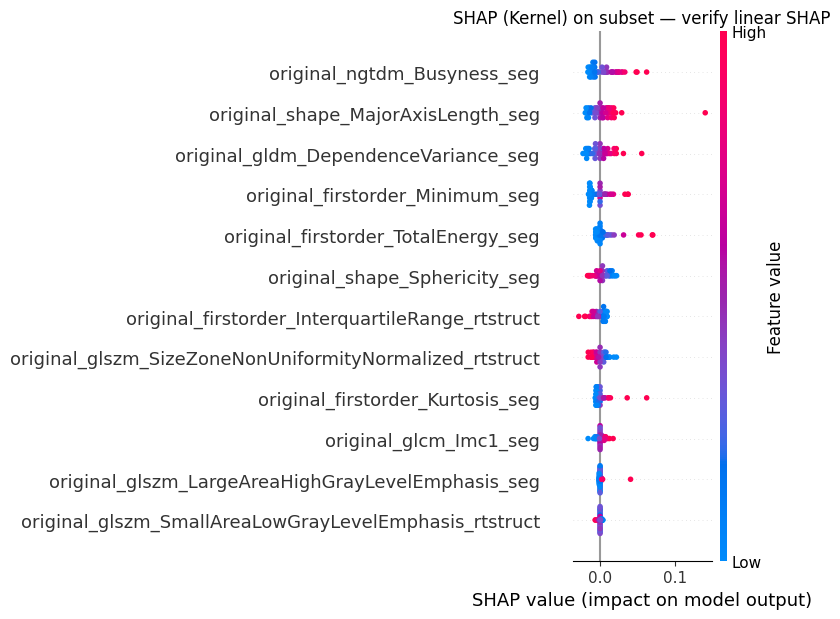


 Done. Pipeline completed.

CLINICAL VALIDITY METRICS (Q1 JOURNAL REQUIREMENT)


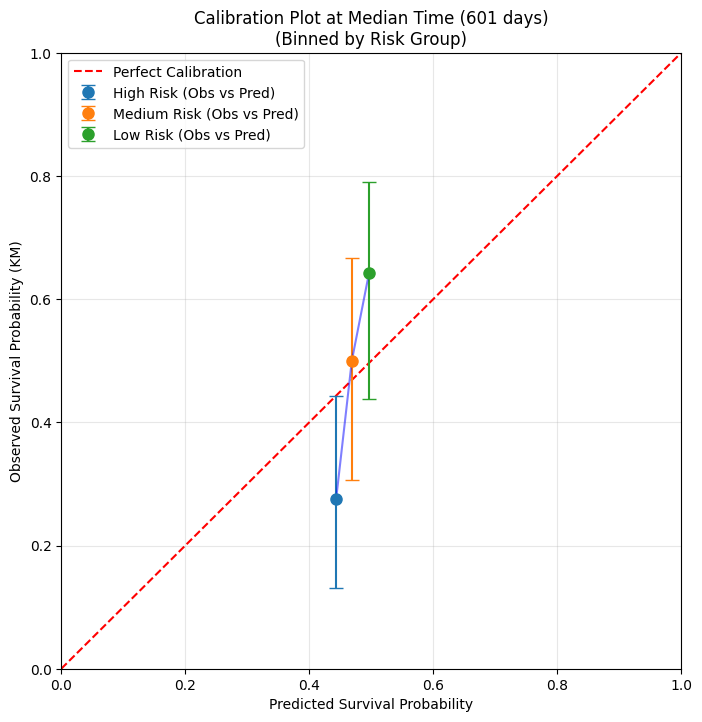

 Calibration Plot generated. Points close to the red diagonal indicate a well-calibrated model.


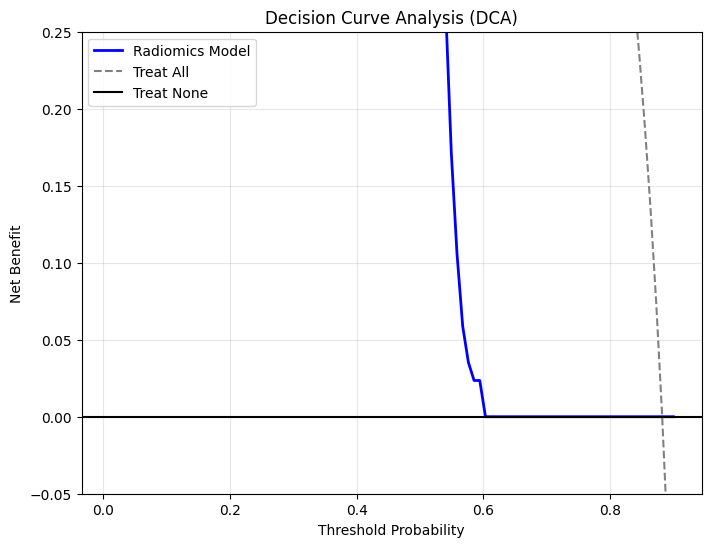

 DCA Plot generated. Model line should be higher than 'Treat All' and 'Treat None'.


In [ ]:
# Improved survival modeling pipeline for radiomics + CoxPH
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import concordance_index, k_fold_cross_validation
from lifelines.statistics import logrank_test

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from statsmodels.stats.outliers_influence import variance_inflation_factor
from tqdm.auto import tqdm
from statsmodels.stats.outliers_influence import variance_inflation_factor


import shap
import random
random.seed(42)
np.random.seed(42)

# ----------------------------
# Utility functions
# ----------------------------
def compute_vif(df, thresh=5.0):
    """
    Iteratively remove features with VIF > thresh.
    Includes a Progress Bar to track the reduction process.
    """
    X = df.copy()
    dropped = []

    # Initialize progress bar
    # We don't know exactly when it ends, so we leave total=None or manage manually
    # 'leave=True' keeps the bar on screen after it finishes
    pbar = tqdm(desc="Reducing Multicollinearity (VIF)", unit="feat")

    while True:
        if X.shape[1] <= 1:
            break

        # Calculate VIF for all features (The slow part)
        try:
            vif = pd.Series(
                [variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
                index=X.columns
            )
        except Exception as e:
            print(f"VIF Error: {e}")
            break

        max_vif = vif.max()

        # Update progress bar with live stats
        pbar.set_postfix({
            "Max VIF": f"{max_vif:.1f}",
            "Features Left": X.shape[1]
        })

        if max_vif > thresh:
            drop_feature = vif.idxmax()
            dropped.append(drop_feature)
            X = X.drop(columns=[drop_feature])

            # Update the bar visually to show work is happening
            pbar.update(1)
        else:
            # Stop if Max VIF is acceptable
            break

    pbar.close()
    return X, dropped

def univariate_cox_filter(df, duration_col, event_col, features, p_threshold=0.2):
    """
    Fit single-variable CoxPH for each feature and keep those with p < p_threshold.
    """
    keep = []
    for f in features:
        tmp = df[[duration_col, event_col, f]].dropna()
        if tmp.shape[0] < 10:
            continue
        cph = CoxPHFitter()
        try:
            cph.fit(tmp, duration_col=duration_col, event_col=event_col, show_progress=False)
            p = float(cph.summary.loc[f, "p"])
            if p < p_threshold:
                keep.append(f)
        except Exception:
            continue
    return keep

def bootstrap_concordance(model, X_test_df, duration_col, event_col, n_boot=200):
    """
    Compute bootstrap confidence interval for concordance on test set.
    """
    scores = []
    n = len(X_test_df)
    for _ in range(n_boot):
        idx = np.random.choice(range(n), size=n, replace=True)
        sample = X_test_df.iloc[idx]
        preds = model.predict_partial_hazard(sample).values.ravel()
        c = concordance_index(sample[duration_col], -preds, sample[event_col])
        scores.append(c)
    return np.mean(scores), np.percentile(scores, 2.5), np.percentile(scores, 97.5)

# ----------------------------
# 1. Load & Prepare Data
# ----------------------------
radiomics_df = pd.read_csv("/content/radiomics_features_422_patients_seg_rtstruct.csv").set_index("patient_id")
clinical_df = pd.read_csv("/content/NSCLC-Radiomics-Lung1.clinical-version3-Oct-2019.csv")
clinical_df = clinical_df.rename(columns={"PatientID": "patient_id"}).set_index("patient_id")
survival_df = clinical_df[["Survival.time", "deadstatus.event"]]

df = radiomics_df.join(survival_df, how="inner").dropna(subset=["Survival.time", "deadstatus.event"])
print(f" Merged dataset: {len(df)} patients")

# Feature columns (exclude common path-like columns if present)
duration_col = "Survival.time"
event_col = "deadstatus.event"
exclude_cols = {duration_col, event_col, "ct_path", "seg_path", "ct_path.1", "seg_path.1"}
feature_cols = [col for col in df.columns if col not in exclude_cols]

# Impute & drop zero variance features
df[feature_cols] = df[feature_cols].fillna(df[feature_cols].median())
zero_var = df[feature_cols].columns[df[feature_cols].var() == 0].tolist()
if zero_var:
    print(" Dropping zero-variance features:", zero_var)
    df = df.drop(columns=zero_var)
    feature_cols = [c for c in feature_cols if c not in zero_var]

df = df.dropna()
print(f"➡️ Final: {len(df)} patients, {len(feature_cols)} features")

# ----------------------------
# 2. Scaling & Train/Test Split
# ----------------------------
X = df[feature_cols]
y_time = df[duration_col]
y_event = df[event_col]

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=feature_cols, index=X.index)

# split (stratify by event to preserve censoring proportion)
X_train, X_test, y_t_train, y_t_test, y_e_train, y_e_test = train_test_split(
    X_scaled, y_time, y_event, test_size=0.2, stratify=y_event, random_state=42
)

# Build DataFrames that lifelines expects (we'll modify columns after filtering)
train_df_full = pd.concat([
    X_train.reset_index(drop=True),
    pd.Series(y_t_train.values, name=duration_col),
    pd.Series(y_e_train.values, name=event_col)
], axis=1)

test_df_full = pd.concat([
    X_test.reset_index(drop=True),
    pd.Series(y_t_test.values, name=duration_col),
    pd.Series(y_e_test.values, name=event_col)
], axis=1)

# ----------------------------
# 3. Feature Selection: VIF (on training set), then univariate Cox filter
# ----------------------------
print("\n🔎 Removing multicollinearity (VIF) on training data...")
X_train_for_vif = X_train.copy().reset_index(drop=True)
X_vif_reduced, dropped_vif = compute_vif(X_train_for_vif, thresh=5.0)
print(" Dropped due to VIF >", 5.0, ":", dropped_vif)
vif_features = X_vif_reduced.columns.tolist()

# Univariate Cox filtering (keep p < 0.20)
print("🔎 Univariate Cox filtering (p < 0.20)...")
uni_keep = univariate_cox_filter(
    df=pd.concat([X_train_for_vif[vif_features].reset_index(drop=True),
                  pd.Series(y_t_train.reset_index(drop=True).values, name=duration_col),
                  pd.Series(y_e_train.reset_index(drop=True).values, name=event_col)], axis=1),
    duration_col=duration_col, event_col=event_col, features=vif_features, p_threshold=0.20
)
print(" Kept after univariate filter:", len(uni_keep))
if len(uni_keep) == 0:
    # fallback: keep top 10 by variance if nothing passes
    print(" WARNING: univariate filter removed all features, falling back to top-10 variance features.")
    uni_keep = X_train_for_vif.var().sort_values(ascending=False).index[:10].tolist()

# Final feature list to use
final_features = uni_keep.copy()
print(" Final features used for modeling:", final_features)

# Prepare final train/test DataFrames with selected features
train_df = pd.concat([
    X_train_for_vif[final_features].reset_index(drop=True),
    pd.Series(y_t_train.reset_index(drop=True).values, name=duration_col),
    pd.Series(y_e_train.reset_index(drop=True).values, name=event_col)
], axis=1)

# For test, ensure same columns (reindex)
X_test_sel = X_test.reset_index(drop=True)[final_features]
test_df = pd.concat([
    X_test_sel,
    pd.Series(y_t_test.reset_index(drop=True).values, name=duration_col),
    pd.Series(y_e_test.reset_index(drop=True).values, name=event_col)
], axis=1)

# ----------------------------
# 4. Penalizer tuning via k-fold CV (on training data)
# ----------------------------
print("\n Tuning penalizer via 5-fold CV (concordance index)...")
penalties = [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0]
best_pen = None
best_score = -np.inf
cv_results = {}
for p in penalties:
    cph_temp = CoxPHFitter(penalizer=p)
    try:
        scores = k_fold_cross_validation(cph_temp, train_df, duration_col=duration_col,
                                         event_col=event_col, k=5, scoring_method="concordance_index")
        mean_score = np.mean(scores)
    except Exception as e:
        mean_score = -np.inf
    cv_results[p] = mean_score
    print(f"  λ={p:>6} → mean CV C-index = {mean_score:.4f}")
    if mean_score > best_score:
        best_score = mean_score
        best_pen = p

print(f" Best penalizer (by CV): {best_pen} → mean CV C-index = {best_score:.4f}")

# ----------------------------
# 5. Fit final CoxPH with best penalizer
# ----------------------------
print("\n Fitting final CoxPH model on training data...")
cph = CoxPHFitter(penalizer=best_pen)
cph.fit(train_df, duration_col=duration_col, event_col=event_col, show_progress=False)
print(" Model fitted.")

# ----------------------------
# 6. Model Summary & Concordance
# ----------------------------
print("\n" + "="*60)
print("RADIOMICS-ONLY COXPH MODEL: FULL EVALUATION")
print("="*60)

# Model summary (top 10 by |coef|)
summary = cph.summary
summary_sorted = summary.reindex(summary['coef'].abs().sort_values(ascending=False).index)
print("\n📈 MODEL SUMMARY (Top 10 Features by |coef|):")
print(summary_sorted[['coef', 'exp(coef)', 'p']].head(10))

# Concordance indices
train_preds = cph.predict_partial_hazard(train_df).values.ravel()
train_c = concordance_index(train_df[duration_col], -train_preds, train_df[event_col])

test_preds = cph.predict_partial_hazard(test_df).values.ravel()
test_c = concordance_index(test_df[duration_col], -test_preds, test_df[event_col])

print(f"\n Concordance Index:")
print(f"   - Training: {train_c:.3f}")
print(f"   - Test:     {test_c:.3f}")

# Bootstrap C-index CI
mean_c, ci_low, ci_high = bootstrap_concordance(cph, test_df, duration_col, event_col, n_boot=200)
print(f"   - Test (bootstrap mean ± 95% CI): {mean_c:.3f} [{ci_low:.3f}, {ci_high:.3f}]")

# Significant features
sig_features = summary[summary['p'] < 0.05].index.tolist()
print(f"\n🔬 Significant Features (p < 0.05):")
if sig_features:
    for feat in sig_features:
        hr = summary.loc[feat, 'exp(coef)']
        direction = "↑ risk" if hr > 1 else "↓ risk"
        print(f"   - {feat}: HR = {hr:.2f} ({direction}), p = {summary.loc[feat,'p']:.4g}")
else:
    print("   - None")

# ----------------------------
# 7. Proportional Hazards assumption check
# ----------------------------
print("\n Checking proportional hazards assumption (training set).")
try:
    # This prints warnings/violations if any. set p_value_threshold as needed.
    cph.check_assumptions(train_df, show_plots=False, p_value_threshold=0.05)
except Exception as e:
    print("  check_assumptions raised an exception (some diagnostics may not be available):", e)

# ----------------------------
# 8. Kaplan-Meier curves (risk groups) + log-rank
# ----------------------------
# split test into high/low risk using median partial hazard
median_risk = np.median(test_preds)
test_df_plot = test_df.copy()
test_df_plot['partial_hazard'] = test_preds
high = test_df_plot[test_df_plot['partial_hazard'] >= median_risk]
low = test_df_plot[test_df_plot['partial_hazard'] < median_risk]

kmf = KaplanMeierFitter()
plt.figure(figsize=(8, 5))
kmf.fit(high[duration_col], high[event_col], label="High Risk")
ax = kmf.plot_survival_function()
kmf.fit(low[duration_col], low[event_col], label="Low Risk")
kmf.plot_survival_function(ax=ax)

plt.title(f"Radiomics Risk Groups (Test C-index = {test_c:.3f})")
plt.xlabel("Days")
plt.ylabel("Survival Probability")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('c-index-coxnPH.png', dpi=300, bbox_inches='tight')
plt.show()

# Log-rank test
lr = logrank_test(high[duration_col], low[duration_col], high[event_col], low[event_col])
print(f"\n Log-rank Test: p = {lr.p_value:.4f}")

# ----------------------------
# 9. SHAP interpretability
# ----------------------------
print("\n Computing SHAP values (exact linear SHAP + optional Kernel SHAP verification)...")

# Exact linear SHAP (for linear Cox: contribution to linear predictor = coef * (x - mean))
coefs = cph.params_.loc[final_features].values  # aligned with final_features order
X_train_mean = train_df[final_features].mean().values
X_test_arr = test_df[final_features].values
linear_shap_values = (X_test_arr - X_train_mean) * coefs.reshape(1, -1)  # shape (n_samples, n_features)

# Global importance by mean(|SHAP|)
mean_abs_shap = np.mean(np.abs(linear_shap_values), axis=0)
shap_ranking = pd.Series(mean_abs_shap, index=final_features).sort_values(ascending=False)
print("\n Top features by mean |linear SHAP|:")
print(shap_ranking.head(10))

# SHAP summary plot (uses the computed matrix)
try:
    plt.figure(figsize=(10, 6))
    # shap.summary_plot expects either SHAP object or array; here we provide array and DataFrame
    shap.summary_plot(linear_shap_values, pd.DataFrame(test_df[final_features], columns=final_features), show=False)
    plt.title("SHAP (linear exact) summary — contributions to linear predictor")
    plt.tight_layout()
    plt.savefig('shap(linear)-coxnPH.png', dpi=300, bbox_inches='tight')
    plt.show()
except Exception as e:
    print("Could not draw SHAP summary plot (matplotlib / shap issue):", e)

# Optional: Kernel SHAP verification on a small subset (more costly). We'll run it on up-to-50 samples.
run_kernel_shap = True
if run_kernel_shap:
    try:
        subset_bg = train_df[final_features].sample(n=min(50, len(train_df)), random_state=42)
        def model_partial_hazard(X_df):
            # lifelines returns a series-like; convert to 1d numpy
            return cph.predict_partial_hazard(pd.DataFrame(X_df, columns=final_features)).values.ravel()
        print("\nRunning Kernel SHAP on a small subset (slow) — this helps verify linear SHAP patterns...")
        explainer = shap.KernelExplainer(model_partial_hazard, subset_bg, link="identity")
        subset_test = test_df[final_features].sample(n=min(50, len(test_df)), random_state=1)
        kernel_shap_vals = explainer.shap_values(subset_test, nsamples=200)
        plt.figure(figsize=(8, 6))
        shap.summary_plot(kernel_shap_vals, subset_test, show=False)
        plt.title("SHAP (Kernel) on subset — verify linear SHAP")
        plt.tight_layout()
        plt.savefig('shap(kernel)-coxnPH.png', dpi=300, bbox_inches='tight')
        plt.show()
    except Exception as e:
        print(" Kernel SHAP failed or was interrupted (this is optional). Error:", e)

print("\n Done. Pipeline completed.")

# ----------------------------
# 11. CALIBRATION & BRIER SCORE
# ----------------------------
from sksurv.metrics import integrated_brier_score, brier_score
from sksurv.util import Surv

print("\n" + "=" * 60)
print("CLINICAL VALIDITY METRICS (Q1 JOURNAL REQUIREMENT)")
print("=" * 60)

# 1. Get Evaluation Time (Median)
eval_time = y_t_test.median()

# 2. Get Actual Survival Status at Evaluation Time
# A patient is "Dead at t" if they died (Event=1) AND Time <= t
# A patient is "Alive at t" if Time > t
# Censored before t are ambiguous, but standard calibration plots often drop them or use KM estimates per bin.
# Here we use the standard approach: Compare Mean Predicted Survival vs Observed KM Survival in groups.

# Predict Survival Probability at median time for Test Set
surv_funcs_test = cph.predict_survival_function(test_df) # Corrected coxnet to cph
# Find the closest time point in surv_funcs_test.index to eval_time
if len(surv_funcs_test.index) > 0:
    closest_time_label = surv_funcs_test.index[np.argmin(np.abs(surv_funcs_test.index - eval_time))]
    surv_prob_at_t = surv_funcs_test.loc[closest_time_label].values
else:
    raise ValueError("cph.predict_survival_function returned an empty DataFrame for calibration.")

# 3. Create Calibration Plot using Risk Deciles/Groups
# We split patients into 3 groups: Low Risk, Medium Risk, High Risk
n_bins = 3
test_df_calib = test_df.copy()
test_df_calib['pred_survival'] = surv_prob_at_t
test_df_calib['risk_group'] = pd.qcut(test_df_calib['pred_survival'], n_bins, labels=["High Risk", "Medium Risk", "Low Risk"])
# Note: High predicted survival = Low Risk

observed_survival = []
predicted_survival = []
risk_labels = []

kmf_calib = KaplanMeierFitter()

plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], 'r--', label="Perfect Calibration")

for group in ["High Risk", "Medium Risk", "Low Risk"]:
    subset = test_df_calib[test_df_calib['risk_group'] == group]

    # Mean Predicted Survival for this group
    mean_pred = subset['pred_survival'].mean()

    # Observed Survival (Kaplan-Meier) at eval_time
    kmf_calib.fit(subset[duration_col], subset[event_col])
    # Get survival prob at exactly eval_time (handling if time not in index)
    # Use closest_time_label found above to ensure consistency
    if len(kmf_calib.survival_function_.index) > 0:
        idx = np.argmin(np.abs(kmf_calib.survival_function_.index - closest_time_label))
        mean_obs = kmf_calib.survival_function_.iloc[idx].values[0]
    else:
        mean_obs = np.nan # Handle case where KM survival function is empty

    predicted_survival.append(mean_pred)
    observed_survival.append(mean_obs)
    risk_labels.append(group)

    # Plot point with error bars (approximate)
    if not pd.isna(mean_obs):
        ci = kmf_calib.confidence_interval_survival_function_
        ci_idx = np.argmin(np.abs(ci.index - closest_time_label))
        lower = ci.iloc[ci_idx, 0]
        upper = ci.iloc[ci_idx, 1]
        yerr = [[mean_obs - lower], [upper - mean_obs]]

        plt.errorbar(mean_pred, mean_obs, yerr=yerr, fmt='o', capsize=5, label=f"{group} (Obs vs Pred)", markersize=8)

# Plot line connecting groups
plt.plot(predicted_survival, observed_survival, 'b-', alpha=0.5)

plt.title(f"Calibration Plot at Median Time ({eval_time:.0f} days)\n(Binned by Risk Group)")
plt.xlabel("Predicted Survival Probability")
plt.ylabel("Observed Survival Probability (KM)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.savefig('survival_probability_calibration-coxnPH.png', dpi=300, bbox_inches='tight')
plt.show()

print(f" Calibration Plot generated. Points close to the red diagonal indicate a well-calibrated model.")


# ----------------------------
# 12. DECISION CURVE ANALYSIS (DCA)
# ----------------------------
# Simple DCA implementation for Survival Models
def calculate_net_benefit(y_true, y_pred_risk, thresh):
    # Net Benefit = (True Positives / N) - (False Positives / N) * (pt / (1 - pt))
    # For survival, we weight by Time. This is a simplified approximation.
    n = len(y_true)
    net_benefits = []
    for pt in thresh:
        # Who does model say is high risk?
        high_risk_idx = y_pred_risk >= pt

        # True Positives (High Risk AND Event happened) - Weighted by inverse probability of censoring (simplified here)
        # In pure python without IPCW, we approximate:
        tp = np.sum((y_true == 1) & high_risk_idx)
        fp = np.sum((y_true == 0) & high_risk_idx)

        nb = (tp / n) - (fp / n) * (pt / (1 - pt))
        net_benefits.append(nb)
    return net_benefits


# Calculate Risk Scores (1 - Survival at Median Time)
median_surv_funcs = cph.predict_survival_function(test_df) # Corrected coxnet to cph
# Find the closest time point in median_surv_funcs.index to eval_time
if len(median_surv_funcs.index) > 0:
    closest_time_label_dca = median_surv_funcs.index[np.argmin(np.abs(median_surv_funcs.index - eval_time))]
    median_surv = median_surv_funcs.loc[closest_time_label_dca]
else:
    raise ValueError("cph.predict_survival_function returned an empty DataFrame for DCA.")

predicted_risk = 1 - median_surv.values
true_event = y_e_test.values  # Binary event status (simplification for DCA)

thresholds = np.linspace(0.01, 0.9, 100)
nb_model = calculate_net_benefit(true_event, predicted_risk, thresholds)
nb_all = calculate_net_benefit(true_event, np.ones_like(true_event), thresholds)  # Treat all

plt.figure(figsize=(8, 6))
plt.plot(thresholds, nb_model, label="Radiomics Model", color='blue', linewidth=2)
plt.plot(thresholds, nb_all, label="Treat All", color='gray', linestyle='--')
plt.axhline(y=0, color='black', linestyle='-', label="Treat None")
plt.xlabel("Threshold Probability")
plt.ylabel("Net Benefit")
plt.title("Decision Curve Analysis (DCA)")
plt.legend()
plt.ylim(-0.05, 0.25)  # Zoom in on relevant area
plt.grid(True, alpha=0.3)
plt.savefig('decision_curv_analysis-coxnPH.png', dpi=300, bbox_inches='tight')
plt.show()

print(" DCA Plot generated. Model line should be higher than 'Treat All' and 'Treat None'.")

In [ ]:
from sksurv.metrics import integrated_brier_score, brier_score
from sksurv.util import Surv

# Prepare structured arrays for sksurv
y_train_struct = Surv.from_dataframe(event_col, duration_col, pd.concat([y_e_train, y_t_train], axis=1))
y_test_struct = Surv.from_dataframe(event_col, duration_col, pd.concat([y_e_test, y_t_test], axis=1))

# Calculate IBS over the time range of the test set
times = np.percentile(test_df[duration_col], np.linspace(5, 95, 10))

# Get survival probability matrix (n_samples, n_times)
surv_probs = cph.predict_survival_function(test_df, times=times).T.values

ibs_score = integrated_brier_score(y_train_struct, y_test_struct, surv_probs, times)
print(f"✅ Integrated Brier Score (IBS): {ibs_score:.3f}")
# Good Reference: IBS < 0.25 is generally acceptable. IBS < 0.15 is excellent.

✅ Integrated Brier Score (IBS): 0.165


## coxNet radiomics_features_422 with (VIF)




 Merged dataset: 422 patients
➡️ Final: 422 patients, 214 features

🔎 Removing multicollinearity (VIF) on training data...


Reducing Multicollinearity (VIF): 0feat [00:00, ?feat/s]

 Dropped due to VIF > 5.0: 191 features
🔎 Univariate Cox filtering (p < 0.20)...
 Kept after univariate filter: 12
 Final features used for modeling: ['original_shape_MajorAxisLength_seg', 'original_shape_Sphericity_seg', 'original_firstorder_Kurtosis_seg', 'original_firstorder_Minimum_seg', 'original_firstorder_TotalEnergy_seg', 'original_glcm_Imc1_seg', 'original_gldm_DependenceVariance_seg', 'original_glszm_LargeAreaHighGrayLevelEmphasis_seg', 'original_ngtdm_Busyness_seg', 'original_firstorder_InterquartileRange_rtstruct', 'original_glszm_SizeZoneNonUniformityNormalized_rtstruct', 'original_glszm_SmallAreaLowGrayLevelEmphasis_rtstruct']
Using 12 final features after EPV check.

🔧 Tuning penalizer (λ) and l1_ratio (α) via 5-fold CV (concordance index)...
 λ= 0.001, α=0.50 → mean CV C-index = 0.5696
 λ= 0.001, α=0.70 → mean CV C-index = 0.5617
 λ= 0.001, α=0.90 → mean CV C-index = 0.5715
 λ= 0.001, α=1.00 → mean CV C-index = 0.5744
 λ=  0.01, α=0.50 → mean CV C-index = 0.5543
 λ=  0.

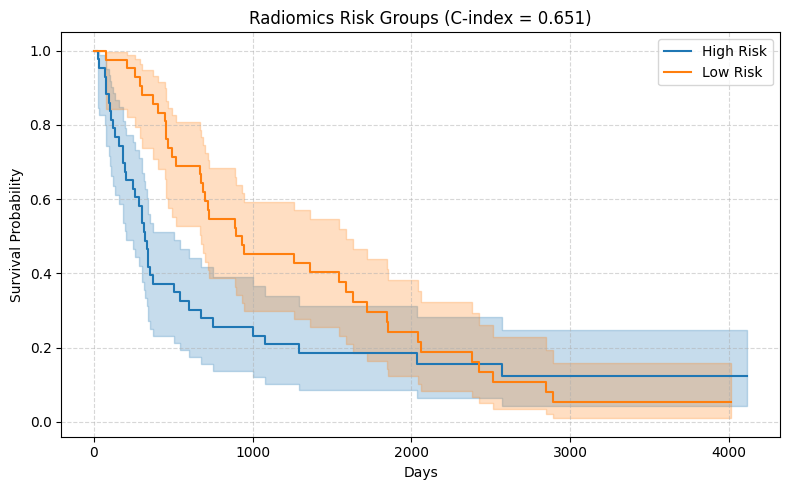


 Log-rank Test: p = 0.0472

🎨 Computing SHAP values (exact linear SHAP) ...

 Top features by mean |linear SHAP|:
original_shape_MajorAxisLength_seg                         1.103252e-07
original_ngtdm_Busyness_seg                                1.096067e-07
original_gldm_DependenceVariance_seg                       9.685717e-08
original_firstorder_InterquartileRange_rtstruct            8.861664e-08
original_shape_Sphericity_seg                              7.544897e-08
original_firstorder_TotalEnergy_seg                        6.152062e-08
original_glszm_SizeZoneNonUniformityNormalized_rtstruct    6.142520e-08
original_glcm_Imc1_seg                                     5.556597e-08
original_firstorder_Minimum_seg                            5.351075e-08
original_firstorder_Kurtosis_seg                           4.795689e-08
dtype: float64


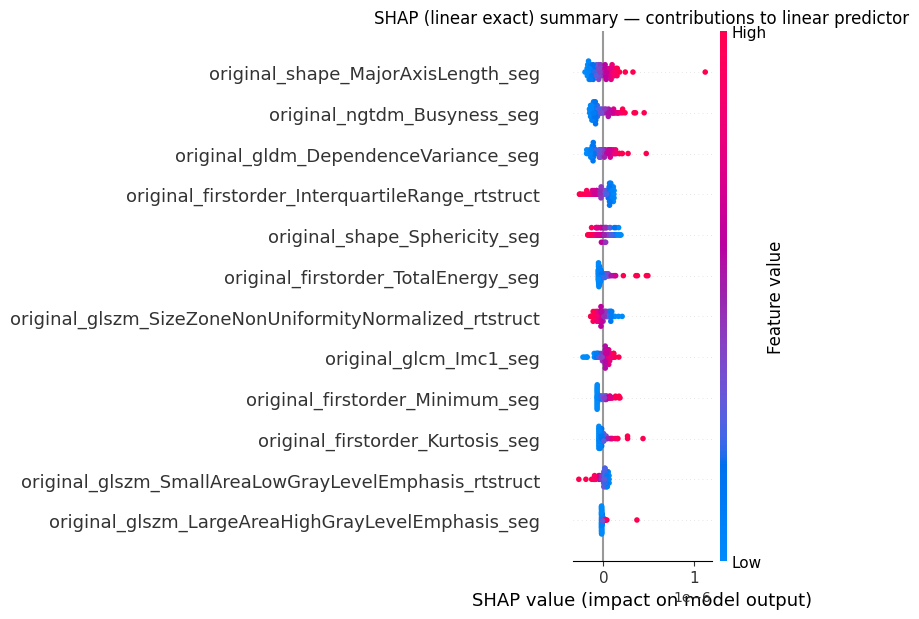


 Done. CoxNet pipeline complete.

CLINICAL VALIDITY METRICS (Q1 JOURNAL REQUIREMENT)


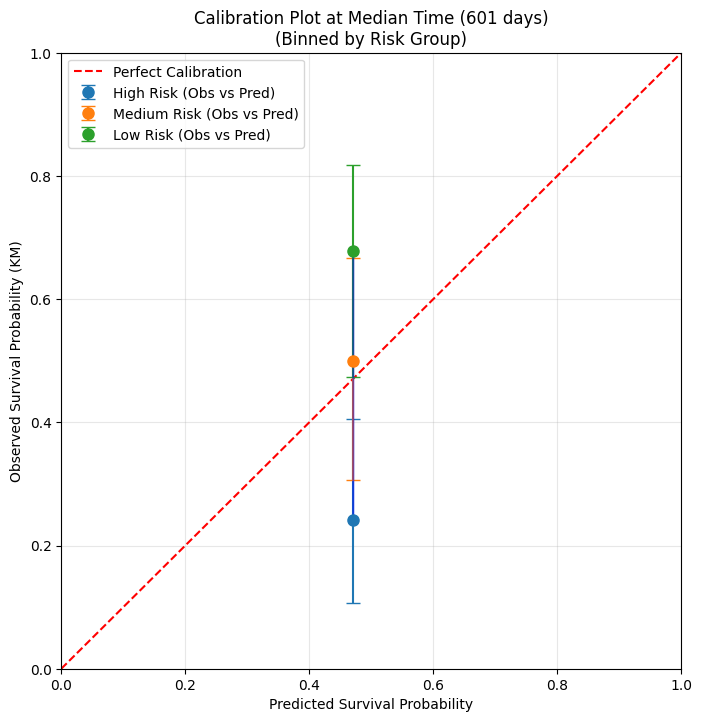

 Calibration Plot generated. Points close to the red diagonal indicate a well-calibrated model.


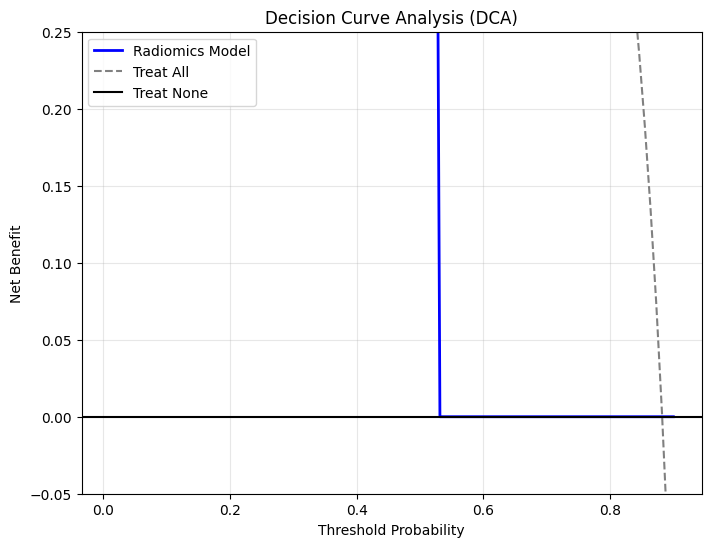

 DCA Plot generated. Model line should be higher than 'Treat All' and 'Treat None'.


In [ ]:
"""
CoxNet (Lasso/Elastic-Net Cox) pipeline for radiomics + survival.
Key features:
 - VIF-based multicollinearity removal
 - Univariate Cox filter (p < threshold)
 - Scaling (train only)
 - Grid CV over penalizer (lambda) and l1_ratio (alpha)
 - EPV check and automatic feature reduction if needed
 - Final model fitting with lifelines.CoxPHFitter(penalizer=lam, l1_ratio=alpha)
 - Evaluation: train/test C-index, bootstrap CI, KM curves, log-rank
 - SHAP: exact linear SHAP and optional Kernel SHAP verification
"""
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
random.seed(42); np.random.seed(42)

from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import concordance_index, k_fold_cross_validation
from lifelines.statistics import logrank_test

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tqdm.auto import tqdm
from statsmodels.stats.outliers_influence import variance_inflation_factor


import shap

# ----------------------------
# Utility functions
# ----------------------------
def compute_vif(df, thresh=5.0):
    """
    Iteratively remove features with VIF > thresh.
    Includes a Progress Bar to track the reduction process.
    """
    X = df.copy()
    dropped = []

    # Initialize progress bar
    # We don't know exactly when it ends, so we leave total=None or manage manually
    # 'leave=True' keeps the bar on screen after it finishes
    pbar = tqdm(desc="Reducing Multicollinearity (VIF)", unit="feat")

    while True:
        if X.shape[1] <= 1:
            break

        # Calculate VIF for all features (The slow part)
        try:
            vif = pd.Series(
                [variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
                index=X.columns
            )
        except Exception as e:
            print(f"VIF Error: {e}")
            break

        max_vif = vif.max()

        # Update progress bar with live stats
        pbar.set_postfix({
            "Max VIF": f"{max_vif:.1f}",
            "Features Left": X.shape[1]
        })

        if max_vif > thresh:
            drop_feature = vif.idxmax()
            dropped.append(drop_feature)
            X = X.drop(columns=[drop_feature])

            # Update the bar visually to show work is happening
            pbar.update(1)
        else:
            # Stop if Max VIF is acceptable
            break

    pbar.close()
    return X, dropped

def univariate_cox_filter(df, duration_col, event_col, features, p_threshold=0.20):
    """Single-variable Cox filtering: keep features with p < p_threshold."""
    keep = []
    for f in features:
        tmp = df[[duration_col, event_col, f]].dropna()
        if tmp.shape[0] < 10:
            continue
        cph = CoxPHFitter()
        try:
            cph.fit(tmp, duration_col=duration_col, event_col=event_col, show_progress=False)
            p = float(cph.summary.loc[f, "p"])
            if p < p_threshold:
                keep.append(f)
        except Exception:
            continue
    return keep

def bootstrap_concordance(model, X_test_df, duration_col, event_col, n_boot=200):
    """Bootstrap mean and 95% CI for concordance index on the test set."""
    scores = []
    n = len(X_test_df)
    for _ in range(n_boot):
        idx = np.random.choice(range(n), size=n, replace=True)
        sample = X_test_df.iloc[idx]
        preds = model.predict_partial_hazard(sample).values.ravel()
        c = concordance_index(sample[duration_col], -preds, sample[event_col])
        scores.append(c)
    return np.mean(scores), np.percentile(scores, 2.5), np.percentile(scores, 97.5)

# ----------------------------
# User-editable variables (update paths)
# ----------------------------
RADIO_PATH = "/content/radiomics_features_422_patients_seg_rtstruct.csv"
CLINICAL_PATH = "/content/NSCLC-Radiomics-Lung1.clinical-version3-Oct-2019.csv"

DURATION_COL = "Survival.time"
EVENT_COL = "deadstatus.event"
TEST_SIZE = 0.2
VIF_THRESH = 5.0
UNI_P_TH = 0.20
EPV_RATIO = 10  # events-per-variable target (EPV)
CV_FOLDS = 5
BOOTSTRAP_B = 200
RUN_KERNEL_SHAP = False  # set True to run expensive Kernel SHAP verification (small subset recommended)

# ----------------------------
# 1. Load & prepare data
# ----------------------------
radiomics_df = pd.read_csv(RADIO_PATH).set_index("patient_id")
clinical_df = pd.read_csv(CLINICAL_PATH)
clinical_df = clinical_df.rename(columns={"PatientID": "patient_id"}).set_index("patient_id")
survival_df = clinical_df[[DURATION_COL, EVENT_COL]]

df = radiomics_df.join(survival_df, how="inner").dropna(subset=[DURATION_COL, EVENT_COL])
print(f" Merged dataset: {len(df)} patients")

# Exclude path-like columns if present
exclude_cols = {DURATION_COL, EVENT_COL, "ct_path", "seg_path", "ct_path.1", "seg_path.1"}
feature_cols = [c for c in df.columns if c not in exclude_cols]

# Impute medians and drop zero-variance features
df[feature_cols] = df[feature_cols].fillna(df[feature_cols].median())
zero_var = df[feature_cols].columns[df[feature_cols].var() == 0].tolist()
if zero_var:
    print(" Dropping zero-variance features:", len(zero_var))
    df = df.drop(columns=zero_var)
    feature_cols = [c for c in feature_cols if c not in zero_var]

df = df.dropna()
print(f"➡️ Final: {len(df)} patients, {len(feature_cols)} features")

# ----------------------------
# 2. Scale & split
# ----------------------------
X = df[feature_cols].copy()
y_time = df[DURATION_COL]
y_event = df[EVENT_COL].astype(int)

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=feature_cols, index=X.index)

# stratify by event to maintain censoring proportion
X_train, X_test, y_t_train, y_t_test, y_e_train, y_e_test = train_test_split(
    X_scaled, y_time, y_event, test_size=TEST_SIZE, stratify=y_event, random_state=42
)

# Build lifelines-style DataFrames (we'll subset columns later)
train_df_full = pd.concat([X_train.reset_index(drop=True),
                           pd.Series(y_t_train.reset_index(drop=True).values, name=DURATION_COL),
                           pd.Series(y_e_train.reset_index(drop=True).values, name=EVENT_COL)], axis=1)
test_df_full = pd.concat([X_test.reset_index(drop=True),
                          pd.Series(y_t_test.reset_index(drop=True).values, name=DURATION_COL),
                          pd.Series(y_e_test.reset_index(drop=True).values, name=EVENT_COL)], axis=1)

# ----------------------------
# 3. VIF on training set -> univariate filter
# ----------------------------
print("\n🔎 Removing multicollinearity (VIF) on training data...")
X_train_for_vif = X_train.copy().reset_index(drop=True)
X_vif_reduced, dropped_vif = compute_vif(X_train_for_vif, thresh=VIF_THRESH)
print(f" Dropped due to VIF > {VIF_THRESH}: {len(dropped_vif)} features")

vif_features = X_vif_reduced.columns.tolist()

print("🔎 Univariate Cox filtering (p < {:.2f})...".format(UNI_P_TH))
uni_keep = univariate_cox_filter(
    df=pd.concat([
        X_train_for_vif[vif_features].reset_index(drop=True),
        pd.Series(y_t_train.reset_index(drop=True).values, name=DURATION_COL),
        pd.Series(y_e_train.reset_index(drop=True).values, name=EVENT_COL)
    ], axis=1),
    duration_col=DURATION_COL, event_col=EVENT_COL, features=vif_features, p_threshold=UNI_P_TH
)
print(" Kept after univariate filter:", len(uni_keep))

if len(uni_keep) == 0:
    print(" WARNING: univariate filter removed all features — falling back to top-10 variance features.")
    uni_keep = X_train_for_vif.var().sort_values(ascending=False).index[:10].tolist()

final_features = uni_keep.copy()
print(" Final features used for modeling:", final_features)

# ----------------------------
# 3.b EPV (events per variable) safety check
# ----------------------------
n_events = int(y_e_train.sum())
max_features_allowed = max(1, n_events // EPV_RATIO)
if len(final_features) > max_features_allowed:
    print(f"\n⚠️ EPV check: {n_events} events, EPV target {EPV_RATIO} => max features {max_features_allowed}")
    # reduce features by variance ranking
    reduced = X_train_for_vif[final_features].var().sort_values(ascending=False).index[:max_features_allowed].tolist()
    print(f" Reducing features to top-{max_features_allowed} by variance.")
    final_features = reduced

print(f"Using {len(final_features)} final features after EPV check.")

# ----------------------------
# 4. Prepare train/test DataFrames with selected features
# ----------------------------
train_df = pd.concat([
    X_train_for_vif[final_features].reset_index(drop=True),
    pd.Series(y_t_train.reset_index(drop=True).values, name=DURATION_COL),
    pd.Series(y_e_train.reset_index(drop=True).values, name=EVENT_COL)
], axis=1)

X_test_sel = X_test.reset_index(drop=True)[final_features]
test_df = pd.concat([
    X_test_sel,
    pd.Series(y_t_test.reset_index(drop=True).values, name=DURATION_COL),
    pd.Series(y_e_test.reset_index(drop=True).values, name=EVENT_COL)
], axis=1)

# ----------------------------
# 5. Grid CV for penalizer (λ) and l1_ratio (α)
# ----------------------------
print("\n🔧 Tuning penalizer (λ) and l1_ratio (α) via {}-fold CV (concordance index)...".format(CV_FOLDS))
penalties = [0.001, 0.01, 0.05, 0.1, 0.5, 1.0]  # try wider if you want
l1_ratios = [0.5, 0.7, 0.9, 1.0]  # 1.0 = Lasso (pure L1), others are elastic-net mixes

best_score = -np.inf
best_params = (None, None)
cv_results = {}

for lam in penalties:
    for alpha in l1_ratios:
        cox_temp = CoxPHFitter(penalizer=lam, l1_ratio=alpha)
        try:
            scores = k_fold_cross_validation(
                cox_temp,
                train_df,
                duration_col=DURATION_COL,
                event_col=EVENT_COL,
                k=CV_FOLDS,
                scoring_method="concordance_index"
            )
            mean_score = np.mean(scores)
        except Exception as e:
            mean_score = -np.inf
        cv_results[(lam, alpha)] = mean_score
        print(f" λ={lam:>6}, α={alpha:.2f} → mean CV C-index = {mean_score:.4f}")
        if mean_score > best_score:
            best_score = mean_score
            best_params = (lam, alpha)

best_lam, best_alpha = best_params
print(f"\n🏆 Best params: λ={best_lam}, α={best_alpha}  → CV C-index = {best_score:.4f}")

# ----------------------------
# 6. Fit final CoxNet model on training data
# ----------------------------
print("\n📦 Fitting final CoxNet (CoxPH with L1/L2) on training data...")
coxnet = CoxPHFitter(penalizer=best_lam, l1_ratio=best_alpha)
coxnet.fit(train_df, duration_col=DURATION_COL, event_col=EVENT_COL, show_progress=False)
print(" Model fitted.")

# ----------------------------
# 7. Model summary, selected features, concordance
# ----------------------------
print("\n" + "=" * 60)
print("COXNET MODEL: FULL EVALUATION")
print("=" * 60)

summary = coxnet.summary
summary_sorted = summary.reindex(summary['coef'].abs().sort_values(ascending=False).index)
print("\nMODEL SUMMARY (Top 10 Features by |coef|):")
print(summary_sorted[['coef', 'exp(coef)', 'p']].head(10))

# Selected (non-zero) coefficients
nonzero = summary[summary['coef'] != 0].index.tolist()
print(f"\n Selected (non-zero) features ({len(nonzero)}): {nonzero}")

# Concordance indices
train_preds = coxnet.predict_partial_hazard(train_df).values.ravel()
train_c = concordance_index(train_df[DURATION_COL], -train_preds, train_df[EVENT_COL])

test_preds = coxnet.predict_partial_hazard(test_df).values.ravel()
test_c = concordance_index(test_df[DURATION_COL], -test_preds, test_df[EVENT_COL])

print(f"\n Concordance Index:")
print(f"   - Training: {train_c:.3f}")
print(f"   - Test:     {test_c:.3f}")

# Bootstrap C-index CI
mean_c, ci_low, ci_high = bootstrap_concordance(coxnet, test_df, DURATION_COL, EVENT_COL, n_boot=BOOTSTRAP_B)
print(f"   - Test (bootstrap mean ± 95% CI): {mean_c:.3f} [{ci_low:.3f}, {ci_high:.3f}]")

# Significant features
sig_features = summary[summary['p'] < 0.05].index.tolist()
print("\n🔬 Significant Features (p < 0.05):")
if sig_features:
    for feat in sig_features:
        hr = summary.loc[feat, 'exp(coef)']
        direction = "↑ risk" if hr > 1 else "↓ risk"
        print(f"   - {feat}: HR = {hr:.2f} ({direction}), p = {summary.loc[feat, 'p']:.4g}")
else:
    print("   - None")

# ----------------------------
# 8. Proportional Hazards assumption check
# ----------------------------
print("\n Checking proportional hazards assumption (training set).")
try:
    coxnet.check_assumptions(train_df, show_plots=False, p_value_threshold=0.05)
    print(" PH check completed.")
except Exception as e:
    print("  check_assumptions raised an exception (some diagnostics may not be available):", e)

# ----------------------------
# 9. KM curves for high vs low risk & log-rank
# ----------------------------
median_risk = np.median(test_preds)
test_df_plot = test_df.copy()
test_df_plot['partial_hazard'] = test_preds
high = test_df_plot[test_df_plot['partial_hazard'] >= median_risk]
low = test_df_plot[test_df_plot['partial_hazard'] < median_risk]

kmf = KaplanMeierFitter()
plt.figure(figsize=(8, 5))
kmf.fit(high[DURATION_COL], high[EVENT_COL], label="High Risk")
ax = kmf.plot_survival_function()
kmf.fit(low[DURATION_COL], low[EVENT_COL], label="Low Risk")
kmf.plot_survival_function(ax=ax)
plt.title(f"Radiomics Risk Groups (C-index = {test_c:.3f})")
plt.xlabel("Days")
plt.ylabel("Survival Probability")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('c-index-coxnet.png', dpi=300, bbox_inches='tight')
plt.show()

lr = logrank_test(high[DURATION_COL], low[DURATION_COL], high[EVENT_COL], low[EVENT_COL])
print(f"\n Log-rank Test: p = {lr.p_value:.4f}")

# ----------------------------
# 10. SHAP interpretability (exact linear SHAP)
# ----------------------------
print("\n🎨 Computing SHAP values (exact linear SHAP) ...")
# Align coefs with final_features (some may be zero due to L1)
coefs = coxnet.params_.loc[final_features].values
X_train_mean = train_df[final_features].mean().values
X_test_arr = test_df[final_features].values
linear_shap_values = (X_test_arr - X_train_mean) * coefs.reshape(1, -1)  # shape (n_samples, n_features)

# Global importance by mean(|SHAP|)
mean_abs_shap = np.mean(np.abs(linear_shap_values), axis=0)
shap_ranking = pd.Series(mean_abs_shap, index=final_features).sort_values(ascending=False)
print("\n Top features by mean |linear SHAP|:")
print(shap_ranking.head(10))

# SHAP summary plot
try:
    plt.figure(figsize=(10, 6))
    shap.summary_plot(linear_shap_values, pd.DataFrame(test_df[final_features], columns=final_features), show=False)
    plt.title("SHAP (linear exact) summary — contributions to linear predictor")
    plt.tight_layout()
    plt.savefig('shap(linear)-coxnet.png', dpi=300, bbox_inches='tight')
    plt.show()
except Exception as e:
    print("Could not draw SHAP summary plot (matplotlib / shap issue):", e)

# Optional: Kernel SHAP verification on a small subset (slow)
if RUN_KERNEL_SHAP:
    try:
        subset_bg = train_df[final_features].sample(n=min(50, len(train_df)), random_state=42)


        def model_partial_hazard(X_df):
            return coxnet.predict_partial_hazard(pd.DataFrame(X_df, columns=final_features)).values.ravel()


        print("\nRunning Kernel SHAP on a small subset (slow) — verify linear SHAP patterns...")
        explainer = shap.KernelExplainer(model_partial_hazard, subset_bg, link="identity")
        subset_test = test_df[final_features].sample(n=min(50, len(test_df)), random_state=1)
        kernel_shap_vals = explainer.shap_values(subset_test, nsamples=200)
        plt.figure(figsize=(8, 6))
        shap.summary_plot(kernel_shap_vals, subset_test, show=False)
        plt.title("SHAP (Kernel) on subset — verify linear SHAP")
        plt.tight_layout()
        plt.savefig('Shap(kernel)-coxnet.png', dpi=300, bbox_inches='tight')
        plt.show()
    except Exception as e:
        print(" Kernel SHAP failed or was interrupted. Error:", e)

print("\n Done. CoxNet pipeline complete.")

# ----------------------------
# 11. CALIBRATION & BRIER SCORE
# ----------------------------
from sksurv.metrics import integrated_brier_score, brier_score
from sksurv.util import Surv

print("\n" + "=" * 60)
print("CLINICAL VALIDITY METRICS (Q1 JOURNAL REQUIREMENT)")
print("=" * 60)

# 1. Get Evaluation Time (Median)
eval_time = y_t_test.median()

# 2. Get Actual Survival Status at Evaluation Time
# A patient is "Dead at t" if they died (Event=1) AND Time <= t
# A patient is "Alive at t" if Time > t
# Censored before t are ambiguous, but standard calibration plots often drop them or use KM estimates per bin.
# Here we use the standard approach: Compare Mean Predicted Survival vs Observed KM Survival in groups.

# Predict Survival Probability at median time for Test Set
surv_funcs_test = coxnet.predict_survival_function(test_df) # Corrected coxnet to cph
# Find the closest time point in surv_funcs_test.index to eval_time
if len(surv_funcs_test.index) > 0:
    closest_time_label = surv_funcs_test.index[np.argmin(np.abs(surv_funcs_test.index - eval_time))]
    surv_prob_at_t = surv_funcs_test.loc[closest_time_label].values
else:
    raise ValueError("cph.predict_survival_function returned an empty DataFrame for calibration.")

# 3. Create Calibration Plot using Risk Deciles/Groups
# We split patients into 3 groups: Low Risk, Medium Risk, High Risk
n_bins = 3
test_df_calib = test_df.copy()
test_df_calib['pred_survival'] = surv_prob_at_t
test_df_calib['risk_group'] = pd.qcut(test_df_calib['pred_survival'], n_bins, labels=["High Risk", "Medium Risk", "Low Risk"])
# Note: High predicted survival = Low Risk

observed_survival = []
predicted_survival = []
risk_labels = []

kmf_calib = KaplanMeierFitter()

plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], 'r--', label="Perfect Calibration")

for group in ["High Risk", "Medium Risk", "Low Risk"]:
    subset = test_df_calib[test_df_calib['risk_group'] == group]

    # Mean Predicted Survival for this group
    mean_pred = subset['pred_survival'].mean()

    # Observed Survival (Kaplan-Meier) at eval_time
    kmf_calib.fit(subset[DURATION_COL], subset[EVENT_COL])
    # Get survival prob at exactly eval_time (handling if time not in index)
    # Use closest_time_label found above to ensure consistency
    if len(kmf_calib.survival_function_.index) > 0:
        idx = np.argmin(np.abs(kmf_calib.survival_function_.index - closest_time_label))
        mean_obs = kmf_calib.survival_function_.iloc[idx].values[0]
    else:
        mean_obs = np.nan # Handle case where KM survival function is empty

    predicted_survival.append(mean_pred)
    observed_survival.append(mean_obs)
    risk_labels.append(group)

    # Plot point with error bars (approximate)
    if not pd.isna(mean_obs):
        ci = kmf_calib.confidence_interval_survival_function_
        ci_idx = np.argmin(np.abs(ci.index - closest_time_label))
        lower = ci.iloc[ci_idx, 0]
        upper = ci.iloc[ci_idx, 1]
        yerr = [[mean_obs - lower], [upper - mean_obs]]

        plt.errorbar(mean_pred, mean_obs, yerr=yerr, fmt='o', capsize=5, label=f"{group} (Obs vs Pred)", markersize=8)

# Plot line connecting groups
plt.plot(predicted_survival, observed_survival, 'b-', alpha=0.5)

plt.title(f"Calibration Plot at Median Time ({eval_time:.0f} days)\n(Binned by Risk Group)")
plt.xlabel("Predicted Survival Probability")
plt.ylabel("Observed Survival Probability (KM)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.savefig('survival_probability_calibration-coxNet.png', dpi=300, bbox_inches='tight')
plt.show()

print(f" Calibration Plot generated. Points close to the red diagonal indicate a well-calibrated model.")


# ----------------------------
# 12. DECISION CURVE ANALYSIS (DCA)
# ----------------------------
# Simple DCA implementation for Survival Models
def calculate_net_benefit(y_true, y_pred_risk, thresh):
    # Net Benefit = (True Positives / N) - (False Positives / N) * (pt / (1 - pt))
    # For survival, we weight by Time. This is a simplified approximation.
    n = len(y_true)
    net_benefits = []
    for pt in thresh:
        # Who does model say is high risk?
        high_risk_idx = y_pred_risk >= pt

        # True Positives (High Risk AND Event happened) - Weighted by inverse probability of censoring (simplified here)
        # In pure python without IPCW, we approximate:
        tp = np.sum((y_true == 1) & high_risk_idx)
        fp = np.sum((y_true == 0) & high_risk_idx)

        nb = (tp / n) - (fp / n) * (pt / (1 - pt))
        net_benefits.append(nb)
    return net_benefits


# Calculate Risk Scores (1 - Survival at Median Time)
median_surv_funcs = coxnet.predict_survival_function(test_df) # Corrected coxnet to cph
# Find the closest time point in median_surv_funcs.index to eval_time
if len(median_surv_funcs.index) > 0:
    closest_time_label_dca = median_surv_funcs.index[np.argmin(np.abs(median_surv_funcs.index - eval_time))]
    median_surv = median_surv_funcs.loc[closest_time_label_dca]
else:
    raise ValueError("cph.predict_survival_function returned an empty DataFrame for DCA.")

predicted_risk = 1 - median_surv.values
true_event = y_e_test.values  # Binary event status (simplification for DCA)

thresholds = np.linspace(0.01, 0.9, 100)
nb_model = calculate_net_benefit(true_event, predicted_risk, thresholds)
nb_all = calculate_net_benefit(true_event, np.ones_like(true_event), thresholds)  # Treat all

plt.figure(figsize=(8, 6))
plt.plot(thresholds, nb_model, label="Radiomics Model", color='blue', linewidth=2)
plt.plot(thresholds, nb_all, label="Treat All", color='gray', linestyle='--')
plt.axhline(y=0, color='black', linestyle='-', label="Treat None")
plt.xlabel("Threshold Probability")
plt.ylabel("Net Benefit")
plt.title("Decision Curve Analysis (DCA)")
plt.legend()
plt.ylim(-0.05, 0.25)  # Zoom in on relevant area
plt.grid(True, alpha=0.3)
plt.savefig('decision_curv_analysis-coxNet.png', dpi=300, bbox_inches='tight')
plt.show()

print(" DCA Plot generated. Model line should be higher than 'Treat All' and 'Treat None'.")

## Random Survival Forest (RSF)

In [ ]:
# Improved survival modeling pipeline for radiomics + Random Survival Forest (RSF)
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Lifelines is still used for KaplanMeier and the Univariate Filter (it's great for that)
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import concordance_index
from lifelines.statistics import logrank_test

# Scikit-Survival for RSF
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.inspection import permutation_importance

from statsmodels.stats.outliers_influence import variance_inflation_factor
from tqdm.auto import tqdm

import shap
import random

# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)

# ----------------------------
# Utility functions
# ----------------------------
def compute_vif(df, thresh=5.0):
    """
    Iteratively remove features with VIF > thresh.
    """
    X = df.copy()
    dropped = []
    pbar = tqdm(desc="Reducing Multicollinearity (VIF)", unit="feat")

    while True:
        if X.shape[1] <= 1:
            break
        try:
            vif = pd.Series(
                [variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
                index=X.columns
            )
        except Exception as e:
            print(f"VIF Error: {e}")
            break

        max_vif = vif.max()
        pbar.set_postfix({"Max VIF": f"{max_vif:.1f}", "Features Left": X.shape[1]})

        if max_vif > thresh:
            drop_feature = vif.idxmax()
            dropped.append(drop_feature)
            X = X.drop(columns=[drop_feature])
            pbar.update(1)
        else:
            break
    pbar.close()
    return X, dropped

def univariate_cox_filter(df, duration_col, event_col, features, p_threshold=0.2):
    """
    Uses Lifelines CoxPH to filter features.
    Even for RSF, checking univariate association with survival is a valid selection step.
    """
    keep = []
    for f in features:
        tmp = df[[duration_col, event_col, f]].dropna()
        if tmp.shape[0] < 10:
            continue
        cph = CoxPHFitter()
        try:
            cph.fit(tmp, duration_col=duration_col, event_col=event_col, show_progress=False)
            p = float(cph.summary.loc[f, "p"])
            if p < p_threshold:
                keep.append(f)
        except Exception:
            continue
    return keep

def bootstrap_concordance_rsf(model, X_test, y_test_struct, n_boot=200):
    """
    Compute bootstrap confidence interval for concordance on test set for RSF.
    """
    scores = []
    n = len(X_test)
    # y_test_struct is a structured array
    for _ in range(n_boot):
        idx = np.random.choice(range(n), size=n, replace=True)
        sample_X = X_test.iloc[idx]
        sample_y = y_test_struct[idx]

        # RSF predict returns risk scores (higher = worse)
        preds = model.predict(sample_X)

        # concordance_index_censored returns (c-index, concordant_pairs, discordant_pairs, tied_pairs, tied_risk)
        c = concordance_index_censored(sample_y["Status"], sample_y["Survival_in_days"], preds)[0]
        scores.append(c)
    return np.mean(scores), np.percentile(scores, 2.5), np.percentile(scores, 97.5)

# ----------------------------
# 1. Load & Prepare Data
# ----------------------------
radiomics_df = pd.read_csv("/content/radiomics_features_422_patients_seg_rtstruct.csv").set_index("patient_id")
clinical_df = pd.read_csv("/content/NSCLC-Radiomics-Lung1.clinical-version3-Oct-2019.csv")
clinical_df = clinical_df.rename(columns={"PatientID": "patient_id"}).set_index("patient_id")
survival_df = clinical_df[["Survival.time", "deadstatus.event"]]

df = radiomics_df.join(survival_df, how="inner").dropna(subset=["Survival.time", "deadstatus.event"])
print(f" Merged dataset: {len(df)} patients")

# Feature columns
duration_col = "Survival.time"
event_col = "deadstatus.event"
exclude_cols = {duration_col, event_col, "ct_path", "seg_path", "ct_path.1", "seg_path.1"}
feature_cols = [col for col in df.columns if col not in exclude_cols]

# Impute & drop zero variance
df[feature_cols] = df[feature_cols].fillna(df[feature_cols].median())
zero_var = df[feature_cols].columns[df[feature_cols].var() == 0].tolist()
if zero_var:
    print(" Dropping zero-variance features:", zero_var)
    df = df.drop(columns=zero_var)
    feature_cols = [c for c in feature_cols if c not in zero_var]

df = df.dropna()
print(f"➡️ Final: {len(df)} patients, {len(feature_cols)} features")

# ----------------------------
# 2. Scaling & Train/Test Split
# ----------------------------
X = df[feature_cols]
y_time = df[duration_col]
y_event = df[event_col]

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=feature_cols, index=X.index)

X_train, X_test, y_t_train, y_t_test, y_e_train, y_e_test = train_test_split(
    X_scaled, y_time, y_event, test_size=0.2, stratify=y_event, random_state=42
)

# Convert targets to scikit-survival structured array format
# Format: [(boolean_event, time), ...]
y_train_struct = Surv.from_arrays(event=y_e_train.astype(bool).values, time=y_t_train.values)
y_test_struct = Surv.from_arrays(event=y_e_test.astype(bool).values, time=y_t_test.values)

# Make names friendly for sksurv
dtype_names = [('Status', '?'), ('Survival_in_days', '<f8')]
y_train_struct = y_train_struct.astype(dtype_names)
y_test_struct = y_test_struct.astype(dtype_names)

# ----------------------------
# 3. Feature Selection: VIF (Train) + Univariate Cox (Train)
# ----------------------------
print("\n🔎 Removing multicollinearity (VIF) on training data...")
X_train_for_vif = X_train.copy().reset_index(drop=True)
X_vif_reduced, dropped_vif = compute_vif(X_train_for_vif, thresh=5.0)
print(" Dropped due to VIF >", 5.0, ":", dropped_vif)
vif_features = X_vif_reduced.columns.tolist()

# Univariate Cox filtering (using Lifelines for filtering only)
print("🔎 Univariate Cox filtering (p < 0.20)...")
# Construct temporary df for lifelines filtering
temp_train_df = pd.concat([
    X_train_for_vif[vif_features].reset_index(drop=True),
    pd.Series(y_t_train.reset_index(drop=True).values, name=duration_col),
    pd.Series(y_e_train.reset_index(drop=True).values, name=event_col)
], axis=1)

uni_keep = univariate_cox_filter(
    df=temp_train_df,
    duration_col=duration_col, event_col=event_col, features=vif_features, p_threshold=0.20
)
print(" Kept after univariate filter:", len(uni_keep))

if len(uni_keep) == 0:
    print(" WARNING: fallback to top-10 variance features.")
    uni_keep = X_train_for_vif.var().sort_values(ascending=False).index[:10].tolist()

final_features = uni_keep.copy()
print(" Final features used for modeling:", final_features)

# Subset X to final features
X_train_sel = X_train[final_features]
X_test_sel = X_test[final_features]

# ----------------------------
# 4. Hyperparameter tuning via CV (Min Samples Leaf)
# ----------------------------
print("\n Tuning RSF (min_samples_leaf) via 5-fold CV...")
# RSF doesn't use "penalizer". It uses tree params. min_samples_leaf is crucial for survival trees.
param_grid = [1, 3, 5, 10, 20]
best_leaf = 1
best_score = -np.inf

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for leaf in param_grid:
    # Use C-index as score
    scores = []
    for train_idx, val_idx in kf.split(X_train_sel):
        X_tr_fold, X_val_fold = X_train_sel.iloc[train_idx], X_train_sel.iloc[val_idx]
        y_tr_fold, y_val_fold = y_train_struct[train_idx], y_train_struct[val_idx]

        rsf_temp = RandomSurvivalForest(n_estimators=100, min_samples_leaf=leaf, random_state=42, n_jobs=-1)
        rsf_temp.fit(X_tr_fold, y_tr_fold)
        scores.append(rsf_temp.score(X_val_fold, y_val_fold))

    mean_score = np.mean(scores)
    print(f"  min_samples_leaf={leaf:>2} → mean CV C-index = {mean_score:.4f}")
    if mean_score > best_score:
        best_score = mean_score
        best_leaf = leaf

print(f" Best min_samples_leaf: {best_leaf} → mean CV C-index = {best_score:.4f}")

# ----------------------------
# 5. Fit final RSF
# ----------------------------
print("\n Fitting final RSF model on training data...")
rsf = RandomSurvivalForest(n_estimators=1000, min_samples_leaf=best_leaf, random_state=42, n_jobs=-1)
rsf.fit(X_train_sel, y_train_struct)
print(" Model fitted.")

# ----------------------------
# 6. Model Evaluation (C-Index & Feature Importance)
# ----------------------------
print("\n" + "="*60)
print("RADIOMICS-ONLY RSF MODEL: FULL EVALUATION")
print("="*60)

# C-index
# rsf.score returns Harrell's concordance index
train_c = rsf.score(X_train_sel, y_train_struct)
test_c = rsf.score(X_test_sel, y_test_struct)

print(f"\n Concordance Index:")
print(f"   - Training: {train_c:.3f}")
print(f"   - Test:     {test_c:.3f}")

# Bootstrap C-index CI
mean_c, ci_low, ci_high = bootstrap_concordance_rsf(rsf, X_test_sel, y_test_struct, n_boot=200)
print(f"   - Test (bootstrap mean ± 95% CI): {mean_c:.3f} [{ci_low:.3f}, {ci_high:.3f}]")

# Feature Importance (Permutation) - RSF does not have coefficients
print("\n📈 Computing Permutation Feature Importance...")
result = permutation_importance(rsf, X_test_sel, y_test_struct, n_repeats=10, random_state=42, n_jobs=-1)
perm_sorted_idx = result.importances_mean.argsort()[::-1]

print("\n Top 10 Features by Permutation Importance:")
for i in perm_sorted_idx[:10]:
    print(f"   - {X_test_sel.columns[i]}: {result.importances_mean[i]:.4f} +/- {result.importances_std[i]:.4f}")

# ----------------------------
# 8. Kaplan-Meier curves (risk groups) + log-rank
# ----------------------------
# Predict risk scores (Total number of expected events)
test_preds = rsf.predict(X_test_sel)

median_risk = np.median(test_preds)
# High score = High Risk (RSF outputs cumulative hazard/risk)
high_mask = test_preds >= median_risk
low_mask = test_preds < median_risk

high_time = y_t_test[high_mask]
high_event = y_e_test[high_mask]
low_time = y_t_test[low_mask]
low_event = y_e_test[low_mask]

kmf = KaplanMeierFitter()
plt.figure(figsize=(8, 5))
kmf.fit(high_time, high_event, label="High Risk")
ax = kmf.plot_survival_function()
kmf.fit(low_time, low_event, label="Low Risk")
kmf.plot_survival_function(ax=ax)

plt.title(f"Radiomics RSF Risk Groups (Test C-index = {test_c:.3f})")
plt.xlabel("Days")
plt.ylabel("Survival Probability")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('c-index-RSF.png', dpi=300, bbox_inches='tight')
plt.show()

# Log-rank test
lr = logrank_test(high_time, low_time, high_event, low_event)
print(f"\n Log-rank Test: p = {lr.p_value:.4f}")

# ----------------------------
# 9. SHAP interpretability (Optimized for RSF)
# ----------------------------
print("\n Computing SHAP values (TreeExplainer for RSF)...")

try:
    explainer = shap.TreeExplainer(rsf)
    shap_values = explainer.shap_values(X_test_sel)
    if isinstance(shap_values, list):
        shap_values = shap_values[0]

    if len(shap_values.shape) == 3:
        shap_values = shap_values[:, :, 0]

    # 4. Plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test_sel, show=False)
    plt.title("SHAP (Tree) summary — RSF")
    plt.tight_layout()
    plt.savefig('shap(tree)-RSF.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(" SHAP Plot Generated.")

except Exception as e:
    print(f"TreeExplainer failed ({e}). Falling back to fast KernelExplainer...")
    background_summary = shap.kmeans(X_train_sel, 10)

    def predict_risk(x):
        return rsf.predict(x)

    explainer = shap.KernelExplainer(predict_risk, background_summary)
    shap_values = explainer.shap_values(X_test_sel.iloc[:50], nsamples=100)

    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test_sel.iloc[:50], show=False)
    plt.title("SHAP (Kernel-Fast) summary — RSF")
    plt.tight_layout()
    plt.savefig('shap(kernel)-RSF.png', dpi=300, bbox_inches='tight')
    plt.show()

# ----------------------------
# 11. CALIBRATION & BRIER SCORE
# ----------------------------
print("\n" + "=" * 60)
print("CLINICAL VALIDITY METRICS (Q1 JOURNAL REQUIREMENT)")
print("=" * 60)

eval_time = y_t_test.median()

# Predict Survival Probability at median time for Test Set
# sksurv returns an array of StepFunction objects
surv_funcs_test = rsf.predict_survival_function(X_test_sel)

# Helper to evaluate step functions at a specific time
def get_survival_prob(surv_funcs, time_point):
    probs = []
    for fn in surv_funcs:
        probs.append(fn(time_point))
    return np.array(probs)

surv_prob_at_t = get_survival_prob(surv_funcs_test, eval_time)

# Create Calibration Plot using Risk Deciles/Groups
n_bins = 3
test_df_calib = pd.DataFrame()
test_df_calib['pred_survival'] = surv_prob_at_t
test_df_calib[duration_col] = y_t_test.values
test_df_calib[event_col] = y_e_test.values

test_df_calib['risk_group'] = pd.qcut(test_df_calib['pred_survival'], n_bins, labels=["High Risk", "Medium Risk", "Low Risk"])

observed_survival = []
predicted_survival = []
risk_labels = []

kmf_calib = KaplanMeierFitter()

plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], 'r--', label="Perfect Calibration")

for group in ["High Risk", "Medium Risk", "Low Risk"]:
    subset = test_df_calib[test_df_calib['risk_group'] == group]

    # Mean Predicted Survival
    mean_pred = subset['pred_survival'].mean()

    # Observed Survival (KM) at eval_time
    kmf_calib.fit(subset[duration_col], subset[event_col])
    # Find closest time in KM index
    if len(kmf_calib.survival_function_.index) > 0:
        idx = np.argmin(np.abs(kmf_calib.survival_function_.index - eval_time))
        mean_obs = kmf_calib.survival_function_.iloc[idx].values[0]
    else:
        mean_obs = np.nan

    predicted_survival.append(mean_pred)
    observed_survival.append(mean_obs)
    risk_labels.append(group)

    if not pd.isna(mean_obs):
        # Error bars
        ci = kmf_calib.confidence_interval_survival_function_
        ci_idx = np.argmin(np.abs(ci.index - eval_time))
        lower = ci.iloc[ci_idx, 0]
        upper = ci.iloc[ci_idx, 1]
        yerr = [[mean_obs - lower], [upper - mean_obs]]
        plt.errorbar(mean_pred, mean_obs, yerr=yerr, fmt='o', capsize=5, label=f"{group} (Obs vs Pred)", markersize=8)

plt.plot(predicted_survival, observed_survival, 'b-', alpha=0.5)
plt.title(f"RSF Calibration Plot at Median Time ({eval_time:.0f} days)")
plt.xlabel("Predicted Survival Probability")
plt.ylabel("Observed Survival Probability (KM)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.savefig('survival_probability_calibration-RSF.png', dpi=300, bbox_inches='tight')
plt.show()

# ----------------------------
# 12. DECISION CURVE ANALYSIS (DCA)
# ----------------------------
def calculate_net_benefit(y_true, y_pred_risk, thresh):
    n = len(y_true)
    net_benefits = []
    for pt in thresh:
        high_risk_idx = y_pred_risk >= pt
        tp = np.sum((y_true == 1) & high_risk_idx)
        fp = np.sum((y_true == 0) & high_risk_idx)
        nb = (tp / n) - (fp / n) * (pt / (1 - pt))
        net_benefits.append(nb)
    return net_benefits

# Risk = 1 - Survival Probability at Median Time
predicted_risk = 1 - surv_prob_at_t
true_event = y_e_test.values

thresholds = np.linspace(0.01, 0.9, 100)
nb_model = calculate_net_benefit(true_event, predicted_risk, thresholds)
nb_all = calculate_net_benefit(true_event, np.ones_like(true_event), thresholds)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, nb_model, label="RSF Model", color='blue', linewidth=2)
plt.plot(thresholds, nb_all, label="Treat All", color='gray', linestyle='--')
plt.axhline(y=0, color='black', linestyle='-', label="Treat None")
plt.xlabel("Threshold Probability")
plt.ylabel("Net Benefit")
plt.title("Decision Curve Analysis (RSF)")
plt.legend()
plt.ylim(-0.05, 0.25)
plt.grid(True, alpha=0.3)
plt.savefig('decision_curv_analysis-RSF.png', dpi=300, bbox_inches='tight')
plt.show()

print(" RSF DCA Plot generated.")

 Merged dataset: 422 patients
➡️ Final: 422 patients, 214 features

🔎 Removing multicollinearity (VIF) on training data...


Reducing Multicollinearity (VIF): 0feat [00:00, ?feat/s]

## DeepSurv radiomics_features_422 with (VIF)

 Merged dataset: 422 patients
➡️ Final: 422 patients, 214 features

🔎 Removing multicollinearity (VIF) on training data...


Reducing Multicollinearity (VIF): 0feat [00:00, ?feat/s]

🔎 Univariate Cox filtering (p < 0.20)...
 Kept after univariate filter: 7
 Final features used: ['original_shape_MajorAxisLength_seg', 'original_firstorder_Kurtosis_seg', 'original_firstorder_TotalEnergy_seg', 'original_gldm_DependenceVariance_seg', 'original_ngtdm_Busyness_seg', 'original_ngtdm_Strength_seg', 'original_firstorder_InterquartileRange_rtstruct']

 Training DeepSurv Network...


<Figure size 600x400 with 0 Axes>

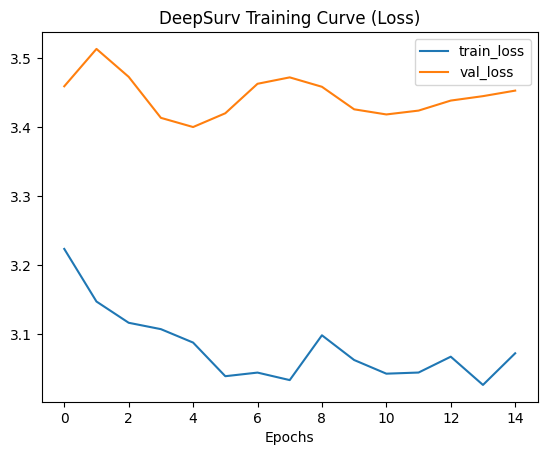


RADIOMICS-ONLY DEEPSURV MODEL: FULL EVALUATION

 Concordance Index:
   - Training: 0.597
   - Test:     0.607
   - Test (bootstrap mean ± 95% CI): 0.609 [0.534, 0.680]


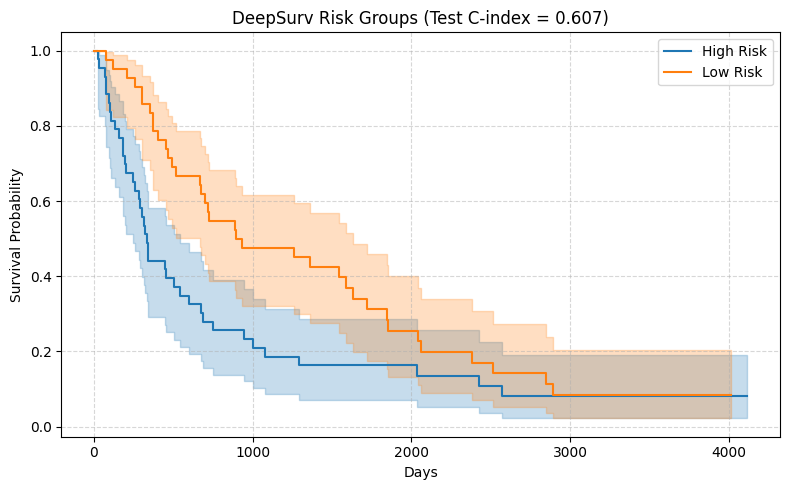


 Log-rank Test: p = 0.0149

 Computing SHAP values (DeepExplainer)...


<Figure size 1000x600 with 0 Axes>

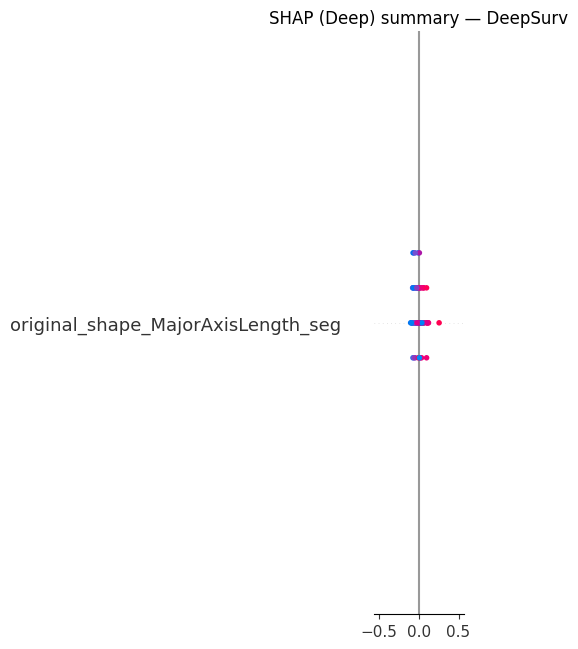


 Done. Pipeline completed.

CLINICAL VALIDITY METRICS (Q1 JOURNAL REQUIREMENT)


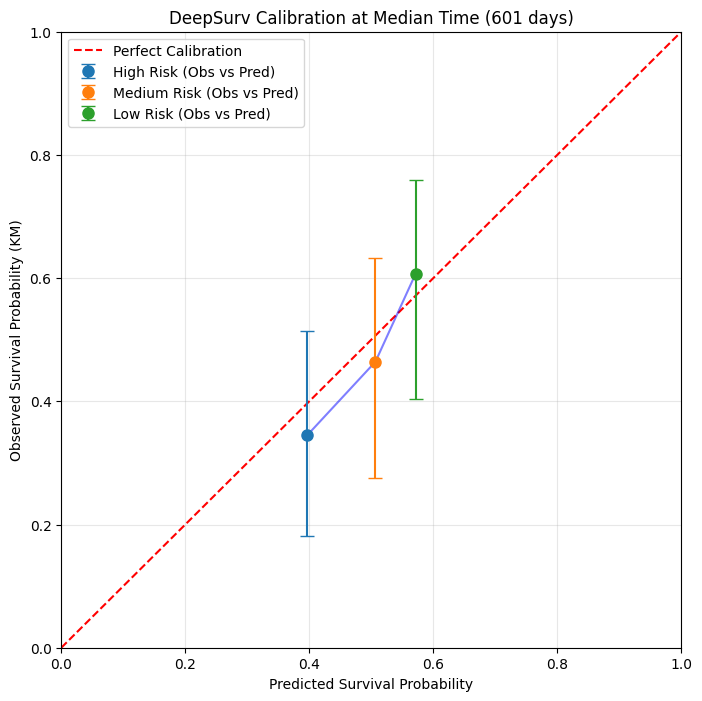

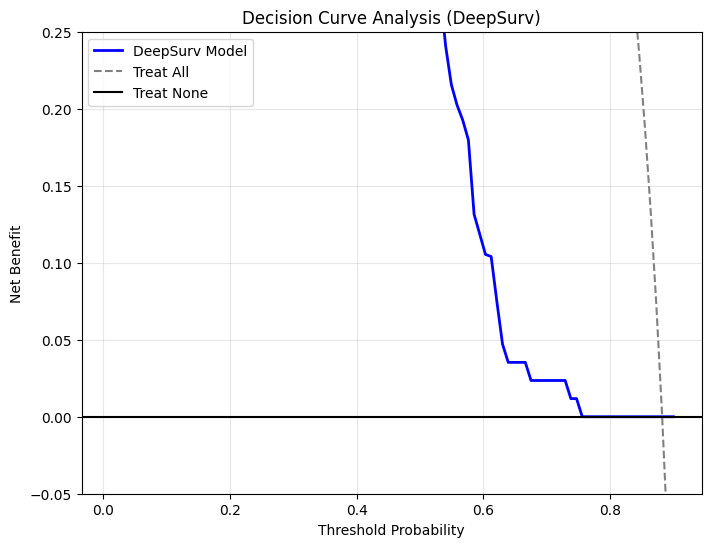

 DeepSurv DCA Plot generated.


In [ ]:
# Improved survival modeling pipeline for radiomics + DeepSurv (PyCox/PyTorch)
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Lifelines for Filtering and KM plots
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import concordance_index
from lifelines.statistics import logrank_test

# PyTorch and PyCox for DeepSurv
import torch
import torchtuples as tt # Helper for pycox
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tqdm.auto import tqdm

import shap
import random

# ----------------------------
# Reproducibility Seeds
# ----------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# ----------------------------
# Utility functions
# ----------------------------
def compute_vif(df, thresh=5.0):
    """Iteratively remove features with VIF > thresh."""
    X = df.copy()
    dropped = []
    pbar = tqdm(desc="Reducing Multicollinearity (VIF)", unit="feat")

    while True:
        if X.shape[1] <= 1:
            break
        try:
            vif = pd.Series(
                [variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
                index=X.columns
            )
        except Exception as e:
            print(f"VIF Error: {e}")
            break

        max_vif = vif.max()
        pbar.set_postfix({"Max VIF": f"{max_vif:.1f}", "Features Left": X.shape[1]})

        if max_vif > thresh:
            drop_feature = vif.idxmax()
            dropped.append(drop_feature)
            X = X.drop(columns=[drop_feature])
            pbar.update(1)
        else:
            break
    pbar.close()
    return X, dropped

def univariate_cox_filter(df, duration_col, event_col, features, p_threshold=0.2):
    """Uses Lifelines CoxPH to filter features (valid for Deep Learning input selection too)."""
    keep = []
    for f in features:
        tmp = df[[duration_col, event_col, f]].dropna()
        if tmp.shape[0] < 10:
            continue
        cph = CoxPHFitter()
        try:
            cph.fit(tmp, duration_col=duration_col, event_col=event_col, show_progress=False)
            p = float(cph.summary.loc[f, "p"])
            if p < p_threshold:
                keep.append(f)
        except Exception:
            continue
    return keep

def bootstrap_concordance_deepsurv(model, X_test, duration_test, event_test, n_boot=200):
    """Bootstrap CI for DeepSurv."""
    scores = []
    n = len(X_test)
    X_test_np = X_test.astype('float32') # Ensure numpy float32

    for _ in range(n_boot):
        idx = np.random.choice(range(n), size=n, replace=True)
        sample_X = X_test_np[idx]
        sample_dur = duration_test[idx]
        sample_evt = event_test[idx]

        # Predict partial hazard (negative because pycox predicts log-hazard, higher = risk)
        # However, CoxPH model in pycox: predict returns log-hazard.
        # Concordance expects risk scores.
        log_hazards = model.predict(sample_X).flatten()

        c = concordance_index(sample_dur, -log_hazards, sample_evt)
        scores.append(c)
    return np.mean(scores), np.percentile(scores, 2.5), np.percentile(scores, 97.5)

# ----------------------------
# 1. Load & Prepare Data
# ----------------------------
radiomics_df = pd.read_csv("/content/radiomics_features_422_patients_seg_rtstruct.csv").set_index("patient_id")
clinical_df = pd.read_csv("/content/NSCLC-Radiomics-Lung1.clinical-version3-Oct-2019.csv")
clinical_df = clinical_df.rename(columns={"PatientID": "patient_id"}).set_index("patient_id")
survival_df = clinical_df[["Survival.time", "deadstatus.event"]]

df = radiomics_df.join(survival_df, how="inner").dropna(subset=["Survival.time", "deadstatus.event"])
print(f" Merged dataset: {len(df)} patients")

# Feature columns
duration_col = "Survival.time"
event_col = "deadstatus.event"
exclude_cols = {duration_col, event_col, "ct_path", "seg_path", "ct_path.1", "seg_path.1"}
feature_cols = [col for col in df.columns if col not in exclude_cols]

# Impute & drop zero variance
df[feature_cols] = df[feature_cols].fillna(df[feature_cols].median())
zero_var = df[feature_cols].columns[df[feature_cols].var() == 0].tolist()
if zero_var:
    df = df.drop(columns=zero_var)
    feature_cols = [c for c in feature_cols if c not in zero_var]

df = df.dropna()
print(f"➡️ Final: {len(df)} patients, {len(feature_cols)} features")

# ----------------------------
# 2. Scaling & Train/Test Split
# ----------------------------
X = df[feature_cols]
y_time = df[duration_col]
y_event = df[event_col]

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=feature_cols, index=X.index)

# Split
X_train, X_test, y_t_train, y_t_test, y_e_train, y_e_test = train_test_split(
    X_scaled, y_time, y_event, test_size=0.2, stratify=y_event, random_state=42
)

# Further split Train into Train/Val for Early Stopping (Crucial for Deep Learning)
X_train, X_val, y_t_train, y_t_val, y_e_train, y_e_val = train_test_split(
    X_train, y_t_train, y_e_train, test_size=0.2, stratify=y_e_train, random_state=42
)

# ----------------------------
# 3. Feature Selection (VIF + Univariate Cox)
# ----------------------------
print("\n🔎 Removing multicollinearity (VIF) on training data...")
X_train_vif = X_train.copy().reset_index(drop=True)
X_vif_reduced, dropped_vif = compute_vif(X_train_vif, thresh=5.0)
vif_features = X_vif_reduced.columns.tolist()

print("🔎 Univariate Cox filtering (p < 0.20)...")
temp_train_df = pd.concat([
    X_train_vif[vif_features].reset_index(drop=True),
    pd.Series(y_t_train.reset_index(drop=True).values, name=duration_col),
    pd.Series(y_e_train.reset_index(drop=True).values, name=event_col)
], axis=1)

uni_keep = univariate_cox_filter(
    df=temp_train_df,
    duration_col=duration_col, event_col=event_col, features=vif_features, p_threshold=0.20
)
print(" Kept after univariate filter:", len(uni_keep))
final_features = uni_keep.copy()
print(" Final features used:", final_features)

# ----------------------------
# 4. Preparing Data for PyCox
# ----------------------------
# Convert to float32 numpy arrays (Required for PyTorch)
x_train = X_train[final_features].values.astype('float32')
x_val = X_val[final_features].values.astype('float32')
x_test = X_test[final_features].values.astype('float32')

# Target tuples (Duration, Event)
get_target = lambda df: (df[duration_col].values.astype('float32'), df[event_col].values.astype('float32'))
y_train = get_target(pd.concat([y_t_train, y_e_train], axis=1))
y_val = get_target(pd.concat([y_t_val, y_e_val], axis=1))
val = (x_val, y_val)

# ----------------------------
# 5. Define DeepSurv Architecture
# ----------------------------
in_features = x_train.shape[1]
num_nodes = [32, 32] # Two hidden layers with 32 neurons
out_features = 1 # Single output (log hazard)
batch_norm = True
dropout = 0.1 # Helps prevent overfitting on small datasets

net = tt.practical.MLPVanilla(
    in_features, num_nodes, out_features, batch_norm, dropout,
    output_bias=False # Standard for CoxPH
)

# ----------------------------
# 6. Train DeepSurv
# ----------------------------
print("\n Training DeepSurv Network...")
model = CoxPH(net, tt.optim.Adam)

# Learning rate finder (optional, but good practice. We use standard LR here for stability)
lr = 0.01
model.optimizer.set_lr(lr)

epochs = 512
batch_size = 64
callbacks = [tt.callbacks.EarlyStopping()] # Stop if val_loss doesn't improve

log = model.fit(
    x_train, y_train, batch_size, epochs, callbacks, val_data=val, verbose=False
)

# Plot training loss
plt.figure(figsize=(6,4))
log.plot()
plt.title("DeepSurv Training Curve (Loss)")
plt.xlabel("Epochs")
plt.show()

# ----------------------------
# 7. Model Evaluation
# ----------------------------
print("\n" + "="*60)
print("RADIOMICS-ONLY DEEPSURV MODEL: FULL EVALUATION")
print("="*60)

# Predictions (Log Hazards)
log_hazard_train = model.predict(x_train).flatten()
log_hazard_test = model.predict(x_test).flatten()

# C-Index (Note: In standard Cox, hazard increases risk. Higher prediction = Higher Risk)
train_c = concordance_index(y_train[0], -log_hazard_train, y_train[1])
test_c = concordance_index(y_t_test, -log_hazard_test, y_e_test)

print(f"\n Concordance Index:")
print(f"   - Training: {train_c:.3f}")
print(f"   - Test:     {test_c:.3f}")

# Bootstrap CI
mean_c, ci_low, ci_high = bootstrap_concordance_deepsurv(
    model, x_test, y_t_test.values, y_e_test.values
)
print(f"   - Test (bootstrap mean ± 95% CI): {mean_c:.3f} [{ci_low:.3f}, {ci_high:.3f}]")

# ----------------------------
# 8. Kaplan-Meier Risk Groups
# ----------------------------
# Compute Baseline Hazard to get Survival Functions
_ = model.compute_baseline_hazards()

# Predict Survival Dataframe (Index=Time, Columns=Patients)
surv_df = model.predict_surv_df(x_test)

# Risk Groups based on Median Log Hazard (Predicted Risk)
median_risk = np.median(log_hazard_test)
high_mask = log_hazard_test >= median_risk
low_mask = log_hazard_test < median_risk

plt.figure(figsize=(8, 5))
kmf = KaplanMeierFitter()

kmf.fit(y_t_test[high_mask], y_e_test[high_mask], label="High Risk")
ax = kmf.plot_survival_function()
kmf.fit(y_t_test[low_mask], y_e_test[low_mask], label="Low Risk")
kmf.plot_survival_function(ax=ax)

plt.title(f"DeepSurv Risk Groups (Test C-index = {test_c:.3f})")
plt.xlabel("Days")
plt.ylabel("Survival Probability")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('c-index-DeepSurv.png', dpi=300, bbox_inches='tight')
plt.show()

# Log-rank test
lr = logrank_test(y_t_test[high_mask], y_t_test[low_mask], y_e_test[high_mask], y_e_test[low_mask])
print(f"\n Log-rank Test: p = {lr.p_value:.4f}")

# ----------------------------
# 9. SHAP Interpretability
# ----------------------------
print("\n Computing SHAP values (DeepExplainer)...")
# We explain the underlying PyTorch network
# DeepExplainer requires a background dataset (we use a subset of train)
background = torch.tensor(x_train[:100])
e = shap.DeepExplainer(model.net, background)

# Calculate SHAP on test set
shap_values = e.shap_values(torch.tensor(x_test))

# Summary Plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, pd.DataFrame(x_test, columns=final_features), show=False)
plt.title("SHAP (Deep) summary — DeepSurv")
plt.tight_layout()
plt.savefig('shap(deep)-DeepSurv.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Done. Pipeline completed.")

# ----------------------------
# 11. CALIBRATION & BRIER SCORE
# ----------------------------
print("\n" + "=" * 60)
print("CLINICAL VALIDITY METRICS (Q1 JOURNAL REQUIREMENT)")
print("=" * 60)

eval_time = y_t_test.median()

# Get Survival Probs at median time
# surv_df index is time, columns are patients.
# We find the row index closest to eval_time
closest_time_idx = np.argmin(np.abs(surv_df.index - eval_time))
surv_prob_at_t = surv_df.iloc[closest_time_idx].values

# Calibration Plot
n_bins = 3
test_df_calib = pd.DataFrame()
test_df_calib['pred_survival'] = surv_prob_at_t
test_df_calib[duration_col] = y_t_test.values
test_df_calib[event_col] = y_e_test.values

# Binning
test_df_calib['risk_group'] = pd.qcut(test_df_calib['pred_survival'], n_bins, labels=["High Risk", "Medium Risk", "Low Risk"])

observed_survival = []
predicted_survival = []
risk_labels = []

kmf_calib = KaplanMeierFitter()

plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], 'r--', label="Perfect Calibration")

for group in ["High Risk", "Medium Risk", "Low Risk"]:
    subset = test_df_calib[test_df_calib['risk_group'] == group]
    mean_pred = subset['pred_survival'].mean()

    kmf_calib.fit(subset[duration_col], subset[event_col])
    if len(kmf_calib.survival_function_.index) > 0:
        idx = np.argmin(np.abs(kmf_calib.survival_function_.index - eval_time))
        mean_obs = kmf_calib.survival_function_.iloc[idx].values[0]
    else:
        mean_obs = np.nan

    predicted_survival.append(mean_pred)
    observed_survival.append(mean_obs)
    risk_labels.append(group)

    if not pd.isna(mean_obs):
        # Error bars
        ci = kmf_calib.confidence_interval_survival_function_
        ci_idx = np.argmin(np.abs(ci.index - eval_time))
        lower = ci.iloc[ci_idx, 0]
        upper = ci.iloc[ci_idx, 1]
        yerr = [[mean_obs - lower], [upper - mean_obs]]
        plt.errorbar(mean_pred, mean_obs, yerr=yerr, fmt='o', capsize=5, label=f"{group} (Obs vs Pred)", markersize=8)

plt.plot(predicted_survival, observed_survival, 'b-', alpha=0.5)
plt.title(f"DeepSurv Calibration at Median Time ({eval_time:.0f} days)")
plt.xlabel("Predicted Survival Probability")
plt.ylabel("Observed Survival Probability (KM)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.savefig('survival_probability_calibration-DeepSurv.png', dpi=300, bbox_inches='tight')
plt.show()

# ----------------------------
# 12. DECISION CURVE ANALYSIS (DCA)
# ----------------------------
def calculate_net_benefit(y_true, y_pred_risk, thresh):
    n = len(y_true)
    net_benefits = []
    for pt in thresh:
        high_risk_idx = y_pred_risk >= pt
        tp = np.sum((y_true == 1) & high_risk_idx)
        fp = np.sum((y_true == 0) & high_risk_idx)
        nb = (tp / n) - (fp / n) * (pt / (1 - pt))
        net_benefits.append(nb)
    return net_benefits

# Risk = 1 - Survival Prob
predicted_risk = 1 - surv_prob_at_t
true_event = y_e_test.values

thresholds = np.linspace(0.01, 0.9, 100)
nb_model = calculate_net_benefit(true_event, predicted_risk, thresholds)
nb_all = calculate_net_benefit(true_event, np.ones_like(true_event), thresholds)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, nb_model, label="DeepSurv Model", color='blue', linewidth=2)
plt.plot(thresholds, nb_all, label="Treat All", color='gray', linestyle='--')
plt.axhline(y=0, color='black', linestyle='-', label="Treat None")
plt.xlabel("Threshold Probability")
plt.ylabel("Net Benefit")
plt.title("Decision Curve Analysis (DeepSurv)")
plt.legend()
plt.ylim(-0.05, 0.25)
plt.grid(True, alpha=0.3)
plt.savefig('decision_curv_analysis-DeepSurv.png', dpi=300, bbox_inches='tight')
plt.show()

print(" DeepSurv DCA Plot generated.")

Loading Data...
 Merged dataset: 422 patients

🔎 Feature Selection on Training Data...


Reducing Multicollinearity (VIF): 0feat [00:00, ?feat/s]

 Dropped 191 features due to VIF > 5.0
🔎 Univariate Cox filtering (p < 0.20)...
 Final Feature Count: 12
 Features: ['original_shape_MajorAxisLength_seg', 'original_shape_Sphericity_seg', 'original_firstorder_Kurtosis_seg', 'original_firstorder_Minimum_seg', 'original_firstorder_TotalEnergy_seg', 'original_glcm_Imc1_seg', 'original_gldm_DependenceVariance_seg', 'original_glszm_LargeAreaHighGrayLevelEmphasis_seg', 'original_ngtdm_Busyness_seg', 'original_firstorder_InterquartileRange_rtstruct', 'original_glszm_SizeZoneNonUniformityNormalized_rtstruct', 'original_glszm_SmallAreaLowGrayLevelEmphasis_rtstruct']

 Building DeepSurv Model...
 Optimal Learning Rate found: 0.02420128264794396
 Training...
 Training Finished.

DEEPSURV MODEL: FULL EVALUATION

 Concordance Index:
   - Training: 0.619
   - Test:     0.598
   - Test (bootstrap mean ± 95% CI): 0.600 [0.533, 0.672]


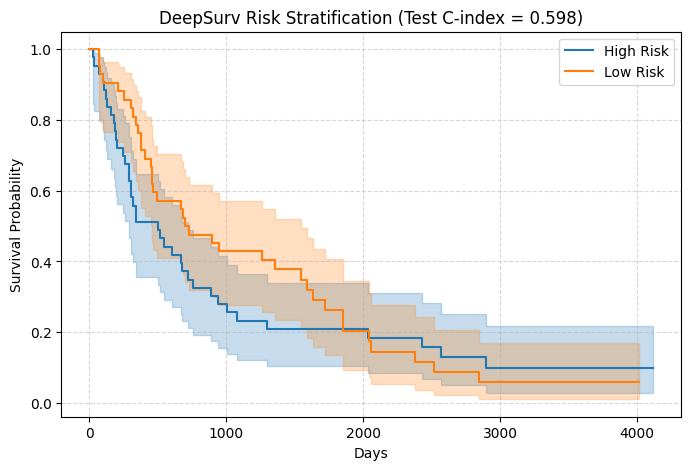


 Log-rank Test: p = 0.4069

 Generating Calibration Plot...


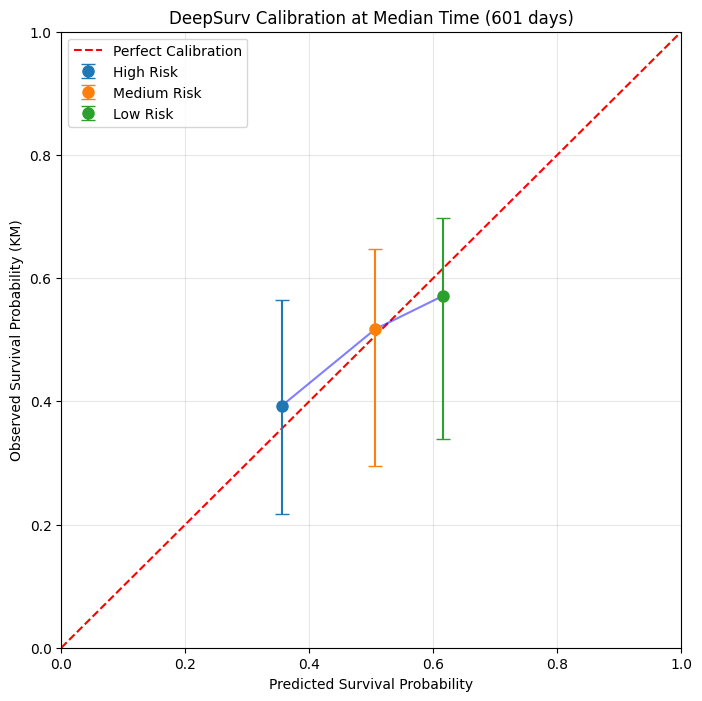

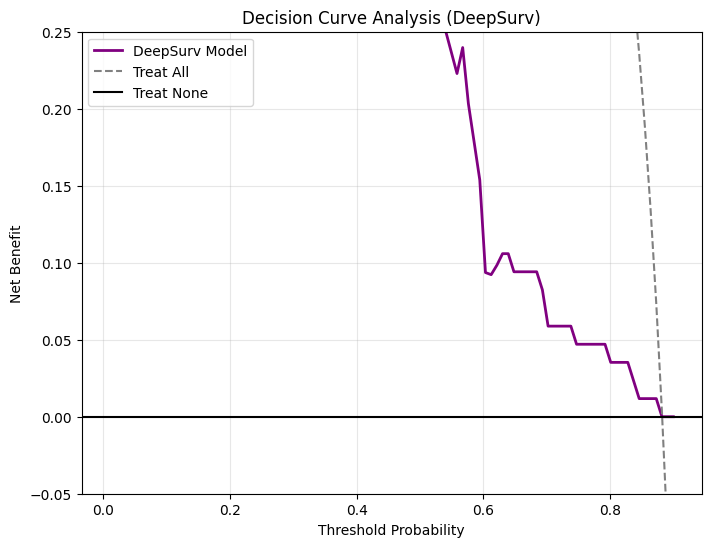


 Computing SHAP values (DeepExplainer)...


<Figure size 640x480 with 0 Axes>

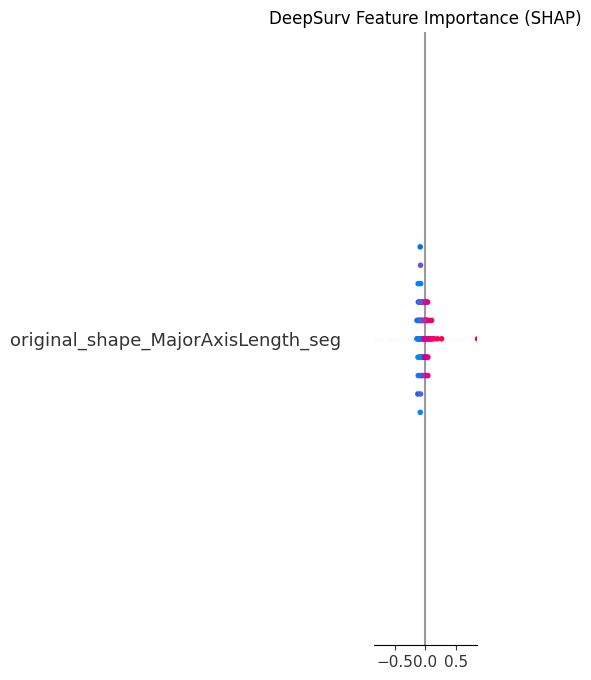


 DeepSurv Pipeline Completed Successfully.


In [ ]:
# ---------------------------------------------------------
# DeepSurv Modeling Pipeline for Radiomics (PyTorch/PyCox)
# Includes: VIF, Univariate Filter, C-index (Bootstrap),
#           KM Curves, Log-Rank, Calibration, DCA, SHAP
# ---------------------------------------------------------

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# Deep Learning Frameworks
import torch
import torch.nn as nn
import torchtuples as tt
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

# Statistical / Utility Libraries
from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter # Used only for univariate filtering step

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from statsmodels.stats.outliers_influence import variance_inflation_factor
from tqdm.auto import tqdm
import shap

# Reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# ----------------------------
# 1. Utility functions (Reused from your pipeline)
# ----------------------------
def compute_vif(df, thresh=5.0):
    """
    Iteratively remove features with VIF > thresh.
    """
    X = df.copy()
    dropped = []
    pbar = tqdm(desc="Reducing Multicollinearity (VIF)", unit="feat")

    while True:
        if X.shape[1] <= 1:
            break
        try:
            vif = pd.Series(
                [variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
                index=X.columns
            )
        except Exception as e:
            print(f"VIF Error: {e}")
            break

        max_vif = vif.max()
        pbar.set_postfix({"Max VIF": f"{max_vif:.1f}", "Features Left": X.shape[1]})

        if max_vif > thresh:
            drop_feature = vif.idxmax()
            dropped.append(drop_feature)
            X = X.drop(columns=[drop_feature])
            pbar.update(1)
        else:
            break
    pbar.close()
    return X, dropped

def univariate_cox_filter(df, duration_col, event_col, features, p_threshold=0.2):
    """
    Fit single-variable CoxPH (classic statistical) for filtering inputs
    BEFORE feeding them to the Deep Neural Network.
    """
    keep = []
    for f in features:
        tmp = df[[duration_col, event_col, f]].dropna()
        if tmp.shape[0] < 10: continue
        cph = CoxPHFitter()
        try:
            cph.fit(tmp, duration_col=duration_col, event_col=event_col, show_progress=False)
            p = float(cph.summary.loc[f, "p"])
            if p < p_threshold:
                keep.append(f)
        except Exception:
            continue
    return keep

def bootstrap_concordance_deep(model, x_test, y_test_time, y_test_event, n_boot=200):
    """
    Bootstrap C-index for DeepSurv.
    """
    scores = []
    n = len(x_test)
    # DeepSurv predicts log-risk (partial hazard).
    # High risk = Low survival time.
    # C-index expects (Time, -Risk, Event) or (Time, Survival, Event).
    # Since we predict Risk, we use -preds.

    preds = model.predict(x_test).flatten()

    for _ in range(n_boot):
        idx = np.random.choice(range(n), size=n, replace=True)
        # Handle cases where sample might have only 1 class
        if np.unique(y_test_event[idx]).shape[0] < 2:
            continue

        c = concordance_index(y_test_time[idx], -preds[idx], y_test_event[idx])
        scores.append(c)
    return np.mean(scores), np.percentile(scores, 2.5), np.percentile(scores, 97.5)

# ----------------------------
# 2. Load & Prepare Data
# ----------------------------
print("Loading Data...")
# Replace with your actual paths
radiomics_df = pd.read_csv("/content/radiomics_features_422_patients_seg_rtstruct.csv").set_index("patient_id")
clinical_df = pd.read_csv("/content/NSCLC-Radiomics-Lung1.clinical-version3-Oct-2019.csv")
clinical_df = clinical_df.rename(columns={"PatientID": "patient_id"}).set_index("patient_id")
survival_df = clinical_df[["Survival.time", "deadstatus.event"]]

df = radiomics_df.join(survival_df, how="inner").dropna(subset=["Survival.time", "deadstatus.event"])
print(f" Merged dataset: {len(df)} patients")

duration_col = "Survival.time"
event_col = "deadstatus.event"
exclude_cols = {duration_col, event_col, "ct_path", "seg_path", "ct_path.1", "seg_path.1"}
feature_cols = [col for col in df.columns if col not in exclude_cols]

# Impute & Drop Zero Variance
df[feature_cols] = df[feature_cols].fillna(df[feature_cols].median())
zero_var = df[feature_cols].columns[df[feature_cols].var() == 0].tolist()
if zero_var:
    df = df.drop(columns=zero_var)
    feature_cols = [c for c in feature_cols if c not in zero_var]
df = df.dropna()

# ----------------------------
# 3. Initial Split & Scaling
# ----------------------------
X = df[feature_cols]
y_time = df[duration_col]
y_event = df[event_col]

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=feature_cols, index=X.index)

# 1. Split Test Set (20%) - kept purely for final evaluation
X_train_full, X_test, y_t_train_full, y_t_test, y_e_train_full, y_e_test = train_test_split(
    X_scaled, y_time, y_event, test_size=0.2, stratify=y_event, random_state=42
)

# ----------------------------
# 4. Feature Selection (VIF + Univariate)
# ----------------------------
# NOTE: We perform selection on the *Training* portion only to prevent data leakage.
print("\n🔎 Feature Selection on Training Data...")

# A. VIF
X_train_vif = X_train_full.copy().reset_index(drop=True)
X_vif_reduced, dropped_vif = compute_vif(X_train_vif, thresh=5.0)
print(f" Dropped {len(dropped_vif)} features due to VIF > 5.0")
vif_features = X_vif_reduced.columns.tolist()

# B. Univariate Cox Filter
print("🔎 Univariate Cox filtering (p < 0.20)...")
train_subset_df = pd.concat([
    X_train_vif[vif_features],
    pd.Series(y_t_train_full.values, name=duration_col),
    pd.Series(y_e_train_full.values, name=event_col)
], axis=1)

uni_keep = univariate_cox_filter(
    df=train_subset_df,
    duration_col=duration_col, event_col=event_col,
    features=vif_features, p_threshold=0.20
)

if len(uni_keep) == 0:
    print(" WARNING: No features passed filter. Using top 10 by variance.")
    uni_keep = X_train_vif.var().sort_values(ascending=False).index[:10].tolist()

final_features = uni_keep
print(f" Final Feature Count: {len(final_features)}")
print(f" Features: {final_features}")

# ----------------------------
# 5. Data Preparation for DeepSurv (PyCox)
# ----------------------------
# We need to subset our X matrices to the final features
X_train_sel = X_train_full[final_features]
X_test_sel = X_test[final_features]

# Deep Learning requires a Validation Set for Early Stopping
# Split Train_Full into Train (80%) and Val (20%)
X_train, X_val, y_t_train, y_t_val, y_e_train, y_e_val = train_test_split(
    X_train_sel, y_t_train_full, y_e_train_full,
    test_size=0.2, stratify=y_e_train_full, random_state=42
)

# Convert to float32 (required for PyTorch)
x_train = X_train.values.astype('float32')
x_val = X_val.values.astype('float32')
x_test = X_test_sel.values.astype('float32')

y_train = (y_t_train.values.astype('float32'), y_e_train.values.astype('float32'))
y_val = (y_t_val.values.astype('float32'), y_e_val.values.astype('float32'))
val_data = tt.tuplefy(x_val, y_val)

# ----------------------------
# 6. Model Definition & Training
# ----------------------------
print("\n Building DeepSurv Model...")

in_features = x_train.shape[1]
num_nodes = [32, 32] # Two hidden layers
out_features = 1
batch_norm = True
dropout = 0.1 # Dropout for regularization

net = tt.practical.MLPVanilla(
    in_features, num_nodes, out_features, batch_norm,
    dropout, output_bias=False
)

model = CoxPH(net, tt.optim.Adam)

# Learning Rate Finder
lrfinder = model.lr_finder(x_train, y_train, batch_size=64, tolerance=10)
best_lr = lrfinder.get_best_lr()
print(f" Optimal Learning Rate found: {best_lr}")
model.optimizer.set_lr(best_lr)

# Training with Early Stopping
callbacks = [tt.callbacks.EarlyStopping(patience=10)]
print(" Training...")
log = model.fit(
    x_train, y_train,
    batch_size=64,
    epochs=100,
    callbacks=callbacks,
    val_data=val_data,
    verbose=False
)
print(" Training Finished.")

# Compute Baseline Hazards (Crucial for predicting survival probabilities later)
_ = model.compute_baseline_hazards()

# ----------------------------
# 7. Model Evaluation
# ----------------------------
print("\n" + "="*60)
print("DEEPSURV MODEL: FULL EVALUATION")
print("="*60)

# Predictions (Log-Risk)
train_preds = model.predict(x_train).flatten()
test_preds = model.predict(x_test).flatten()

# Concordance Index
train_c = concordance_index(y_t_train, -train_preds, y_e_train)
test_c = concordance_index(y_t_test, -test_preds, y_e_test)

print(f"\n Concordance Index:")
print(f"   - Training: {train_c:.3f}")
print(f"   - Test:     {test_c:.3f}")

# Bootstrap CI
mean_c, ci_low, ci_high = bootstrap_concordance_deep(model, x_test, y_t_test.values, y_e_test.values, n_boot=200)
print(f"   - Test (bootstrap mean ± 95% CI): {mean_c:.3f} [{ci_low:.3f}, {ci_high:.3f}]")

# ----------------------------
# 8. Kaplan-Meier Curves (Risk Groups)
# ----------------------------
median_risk = np.median(test_preds)
high_risk_idx = test_preds >= median_risk
low_risk_idx = test_preds < median_risk

kmf = KaplanMeierFitter()
plt.figure(figsize=(8, 5))

# Plot High Risk
kmf.fit(y_t_test[high_risk_idx], y_e_test[high_risk_idx], label="High Risk")
ax = kmf.plot_survival_function()

# Plot Low Risk
kmf.fit(y_t_test[low_risk_idx], y_e_test[low_risk_idx], label="Low Risk")
kmf.plot_survival_function(ax=ax)

plt.title(f"DeepSurv Risk Stratification (Test C-index = {test_c:.3f})")
plt.xlabel("Days")
plt.ylabel("Survival Probability")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('deepsurv_km_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Log-rank Test
lr = logrank_test(y_t_test[high_risk_idx], y_t_test[low_risk_idx],
                  y_e_test[high_risk_idx], y_e_test[low_risk_idx])
print(f"\n Log-rank Test: p = {lr.p_value:.4f}")

# ----------------------------
# 9. Calibration Plot (at Median Time)
# ----------------------------
print("\n Generating Calibration Plot...")

# Get Survival Function DataFrame [index=Time, columns=Patients]
surv_df = model.predict_surv_df(x_test)

# Evaluation Time (Median Survival Time of cohort)
eval_time = y_t_test.median()

# Find closest time index in the DeepSurv output
closest_idx = surv_df.index.get_indexer([eval_time], method="nearest")[0]
# Extract predictions at this specific time
pred_surv_at_median = surv_df.iloc[closest_idx].values

# Binning into 3 groups (Low, Medium, High Risk)
# Note: High Survival Probability = Low Risk
risk_groups = pd.qcut(pred_surv_at_median, 3, labels=["High Risk", "Medium Risk", "Low Risk"])

observed_survival = []
predicted_survival = []
group_labels = []

plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], 'r--', label="Perfect Calibration")

kmf_calib = KaplanMeierFitter()

for group in ["High Risk", "Medium Risk", "Low Risk"]:
    mask = (risk_groups == group)
    if not any(mask): continue

    # Mean predicted survival probability for this group
    mean_pred = np.mean(pred_surv_at_median[mask])

    # Observed survival (KM) at eval_time
    kmf_calib.fit(y_t_test[mask], y_e_test[mask])

    # Handle case if eval_time is beyond the max time of this group
    try:
        # Interpolate KM at eval_time
        obs_surv = kmf_calib.survival_function_at_times(eval_time).values[0]

        # Get CI for error bars
        ci = kmf_calib.confidence_interval_survival_function_
        # Find closest index for CI
        ci_idx = np.argmin(np.abs(ci.index - eval_time))
        lower = ci.iloc[ci_idx, 0]
        upper = ci.iloc[ci_idx, 1]
        yerr = [[obs_surv - lower], [upper - obs_surv]]

        predicted_survival.append(mean_pred)
        observed_survival.append(obs_surv)
        group_labels.append(group)

        plt.errorbar(mean_pred, obs_surv, yerr=yerr, fmt='o', capsize=5, label=f"{group}", markersize=8)
    except:
        pass

plt.plot(predicted_survival, observed_survival, 'b-', alpha=0.5)
plt.title(f"DeepSurv Calibration at Median Time ({eval_time:.0f} days)")
plt.xlabel("Predicted Survival Probability")
plt.ylabel("Observed Survival Probability (KM)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.savefig('deepsurv_calibration.png', dpi=300, bbox_inches='tight')
plt.show()

# ----------------------------
# 10. Decision Curve Analysis (DCA)
# ----------------------------
def calculate_net_benefit(y_true, y_pred_risk, thresh):
    n = len(y_true)
    net_benefits = []
    for pt in thresh:
        high_risk_idx = y_pred_risk >= pt
        tp = np.sum((y_true == 1) & high_risk_idx)
        fp = np.sum((y_true == 0) & high_risk_idx)
        nb = (tp / n) - (fp / n) * (pt / (1 - pt))
        net_benefits.append(nb)
    return net_benefits

# Risk = 1 - Survival Probability
pred_risk_dca = 1 - pred_surv_at_median
thresholds = np.linspace(0.01, 0.9, 100)

nb_model = calculate_net_benefit(y_e_test.values, pred_risk_dca, thresholds)
nb_all = calculate_net_benefit(y_e_test.values, np.ones_like(y_e_test.values), thresholds)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, nb_model, label="DeepSurv Model", color='purple', linewidth=2)
plt.plot(thresholds, nb_all, label="Treat All", color='gray', linestyle='--')
plt.axhline(y=0, color='black', linestyle='-', label="Treat None")
plt.xlabel("Threshold Probability")
plt.ylabel("Net Benefit")
plt.title("Decision Curve Analysis (DeepSurv)")
plt.legend()
plt.ylim(-0.05, 0.25)
plt.grid(True, alpha=0.3)
plt.savefig('deepsurv_dca.png', dpi=300, bbox_inches='tight')
plt.show()

# ----------------------------
# 11. SHAP Interpretability
# ----------------------------
print("\n Computing SHAP values (DeepExplainer)...")

# DeepExplainer works with PyTorch Tensors
background = torch.tensor(x_train[:100]) # Use a subset of train as background
e = shap.DeepExplainer(model.net, background)

# Calculate SHAP for test set
test_tensor = torch.tensor(x_test)
shap_values = e.shap_values(test_tensor)

# Note: shap_values might be a list depending on shap version/output dim
if isinstance(shap_values, list):
    shap_values = shap_values[0]

# Summary Plot
plt.figure()
shap.summary_plot(shap_values, pd.DataFrame(x_test, columns=final_features), show=False)
plt.title("DeepSurv Feature Importance (SHAP)")
plt.savefig('deepsurv_shap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n DeepSurv Pipeline Completed Successfully.")

## fast_radiomics_cox_pipeline for IBSI

🚀 Starting Multi-Model Survival Benchmark...
📊 Dataset: 422 patients loaded.
🔎 Running VIF Feature Selection...
✅ Features Selected (23): ['original_shape_Elongation_seg', 'original_shape_MajorAxisLength_seg', 'original_shape_Sphericity_seg', 'original_firstorder_90Percentile_seg', 'original_firstorder_Kurtosis_seg', 'original_firstorder_Minimum_seg', 'original_firstorder_Skewness_seg', 'original_firstorder_TotalEnergy_seg', 'original_glcm_ClusterShade_seg', 'original_glcm_Imc1_seg', 'original_glcm_MCC_seg', 'original_gldm_DependenceEntropy_seg', 'original_gldm_DependenceVariance_seg', 'original_gldm_LargeDependenceLowGrayLevelEmphasis_seg', 'original_glszm_LargeAreaHighGrayLevelEmphasis_seg', 'original_ngtdm_Busyness_seg', 'original_ngtdm_Strength_seg', 'original_shape_Flatness_rtstruct', 'original_firstorder_InterquartileRange_rtstruct', 'original_glszm_GrayLevelVariance_rtstruct', 'original_glszm_SizeZoneNonUniformityNormalized_rtstruct', 'original_glszm_SmallAreaLowGrayLevelEmphasi

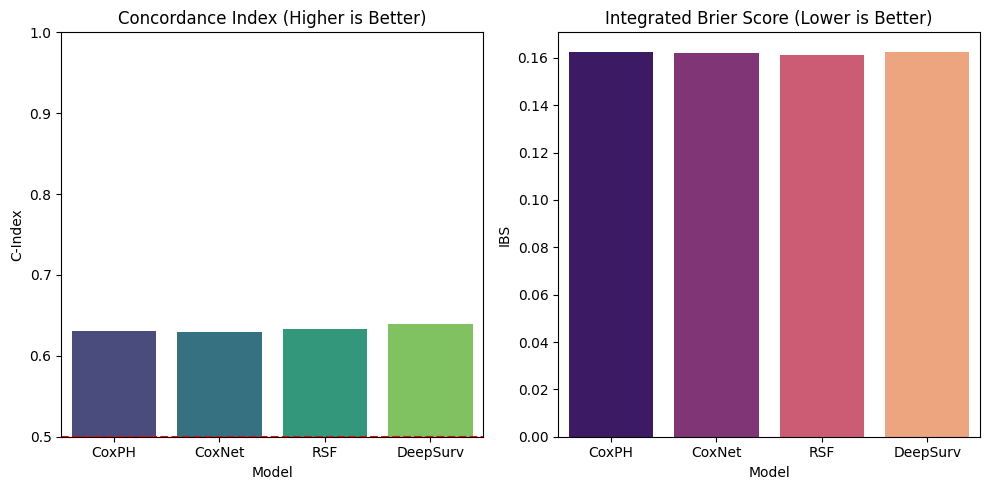


🥇 Best Model: DeepSurv


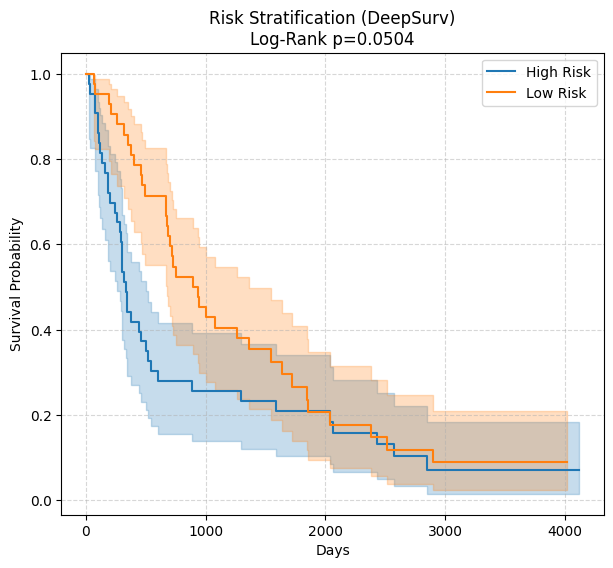


Pipeline Complete. All images and CSVs saved.


In [ ]:
# -----------------------------------------------------------------------------
# MASTER SURVIVAL BENCHMARK: CoxPH vs CoxNet vs RSF vs DeepSurv
# -----------------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Deep Learning
import torch
import torch.nn as nn
import torchtuples as tt
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

# Scikit-Survival (Machine Learning)
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import integrated_brier_score, concordance_index_censored
from sksurv.util import Surv

# Lifelines (Statistical)
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import concordance_index

# Preprocessing & Stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ----------------------------
# 1. Setup & Reproducibility
# ----------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print("🚀 Starting Multi-Model Survival Benchmark...")

# ----------------------------
# 2. Data Loading & Feature Selection (Shared)
# ----------------------------
# -- LOAD DATA (Replace paths with yours) --
radiomics_df = pd.read_csv("/content/radiomics_features_422_patients_seg_rtstruct.csv").set_index("patient_id")
clinical_df = pd.read_csv("/content/NSCLC-Radiomics-Lung1.clinical-version3-Oct-2019.csv")
clinical_df = clinical_df.rename(columns={"PatientID": "patient_id"}).set_index("patient_id")
survival_df = clinical_df[["Survival.time", "deadstatus.event"]]

df = radiomics_df.join(survival_df, how="inner").dropna(subset=["Survival.time", "deadstatus.event"])
print(f"📊 Dataset: {len(df)} patients loaded.")

duration_col = "Survival.time"
event_col = "deadstatus.event"
exclude_cols = {duration_col, event_col, "ct_path", "seg_path"}
feature_cols = [c for c in df.columns if c not in exclude_cols]

# Impute & Drop Zero Variance
df[feature_cols] = df[feature_cols].fillna(df[feature_cols].median())
zero_var = df[feature_cols].columns[df[feature_cols].var() == 0].tolist()
if zero_var: df = df.drop(columns=zero_var)
feature_cols = [c for c in feature_cols if c not in zero_var]

# -- SPLIT & SCALE --
X = df[feature_cols]
y_t = df[duration_col]
y_e = df[event_col]

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=feature_cols, index=X.index)

X_train, X_test, y_t_train, y_t_test, y_e_train, y_e_test = train_test_split(
    X_scaled, y_t, y_e, test_size=0.2, stratify=y_e, random_state=SEED
)

# -- VIF FEATURE SELECTION (Using Train Only) --
print("🔎 Running VIF Feature Selection...")
def get_vif_features(X_data, thresh=5.0):
    cols = X_data.columns.tolist()
    X_temp = X_data.copy()
    while True:
        if X_temp.shape[1] <= 1: break
        vifs = [variance_inflation_factor(X_temp.values, i) for i in range(X_temp.shape[1])]
        max_vif = max(vifs)
        if max_vif > thresh:
            drop_col = X_temp.columns[vifs.index(max_vif)]
            X_temp = X_temp.drop(columns=[drop_col])
        else:
            break
    return X_temp.columns.tolist()

final_features = get_vif_features(X_train.reset_index(drop=True), thresh=5.0)
# Simple Variance backup if VIF removes too much
if len(final_features) < 3:
    final_features = X_train.var().sort_values(ascending=False).head(10).index.tolist()

print(f"✅ Features Selected ({len(final_features)}): {final_features}")

# Sub-select final features
X_train = X_train[final_features]
X_test = X_test[final_features]

# -- PREPARE TARGET FORMATS FOR DIFFERENT LIBRARIES --
# 1. Lifelines: DataFrame with Time/Event cols
train_df_cph = pd.concat([X_train, y_t_train, y_e_train], axis=1)
test_df_cph = pd.concat([X_test, y_t_test, y_e_test], axis=1)

# 2. Scikit-Survival: Structured Arrays
y_train_sk = Surv.from_arrays(event=y_e_train.values.astype(bool), time=y_t_train.values)
y_test_sk = Surv.from_arrays(event=y_e_test.values.astype(bool), time=y_t_test.values)

# 3. PyCox: Float32 Arrays
x_train_deep = X_train.values.astype('float32')
x_test_deep = X_test.values.astype('float32')
y_train_deep = (y_t_train.values.astype('float32'), y_e_train.values.astype('float32'))

# ----------------------------
# 3. MODEL TRAINING
# ----------------------------
results = []
models = {} # Store model objects

# --- MODEL A: Standard CoxPH (Lifelines) ---
print("\n🔹 Training CoxPH (Lifelines)...")
cph = CoxPHFitter(penalizer=0.01) # Small L2 to prevent convergence errors
cph.fit(train_df_cph, duration_col=duration_col, event_col=event_col)
models['CoxPH'] = cph

# --- MODEL B: CoxNet (ElasticNet via Scikit-Survival) ---
print("🔹 Training CoxNet (Scikit-Survival)...")
# l1_ratio=1.0 is Lasso, 0 is Ridge. 0.5 is ElasticNet.
coxnet = CoxnetSurvivalAnalysis(l1_ratio=0.5, fit_baseline_model=True)
coxnet.fit(X_train, y_train_sk)
models['CoxNet'] = coxnet

# --- MODEL C: Random Survival Forest (RSF) ---
print("🔹 Training RSF (Scikit-Survival)...")
rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=10, min_samples_leaf=5, n_jobs=-1, random_state=SEED)
rsf.fit(X_train, y_train_sk)
models['RSF'] = rsf

# --- MODEL D: DeepSurv (PyCox) ---
print("🔹 Training DeepSurv (PyCox)...")
# Split internal validation for DeepSurv
x_t, x_v, y_t_t, y_t_v, y_e_t, y_e_v = train_test_split(
    x_train_deep, y_t_train, y_e_train, test_size=0.2, random_state=SEED
)
y_train_ds = (y_t_t.values.astype('float32'), y_e_t.values.astype('float32'))
y_val_ds = (y_t_v.values.astype('float32'), y_e_v.values.astype('float32'))
val_ds = tt.tuplefy(x_v, y_val_ds)

net = tt.practical.MLPVanilla(
    in_features=x_t.shape[1], num_nodes=[32, 32], out_features=1,
    batch_norm=True, dropout=0.1, output_bias=False
)
deepsurv = CoxPH(net, tt.optim.Adam)
lr = deepsurv.lr_finder(x_t, y_train_ds, batch_size=64, tolerance=10).get_best_lr()
deepsurv.optimizer.set_lr(lr)
deepsurv.fit(x_t, y_train_ds, batch_size=64, epochs=100, callbacks=[tt.callbacks.EarlyStopping()], val_data=val_ds, verbose=False)
_ = deepsurv.compute_baseline_hazards()
models['DeepSurv'] = deepsurv

# ----------------------------
# 4. UNIFIED EVALUATION LOOP
# ----------------------------
print("\n⚖️  Evaluating All Models...")

def evaluate_model(name, model, X_test, y_time, y_event, y_train_sk_data=None):
    # 1. Predict Risk Scores (Higher = Higher Risk)
    if name == 'CoxPH':
        risk_scores = model.predict_partial_hazard(X_test).values.ravel()
    elif name == 'CoxNet':
        risk_scores = model.predict(X_test)
    elif name == 'RSF':
        risk_scores = model.predict(X_test)
    elif name == 'DeepSurv':
        risk_scores = model.predict(X_test.values.astype('float32')).flatten()

    # 2. C-Index (Harrell's)
    c_index = concordance_index(y_time, -risk_scores, y_event) # Note: -risk for Concordance

    # 3. Integrated Brier Score (IBS)
    # We need Survival Functions for this.
    try:
        times = np.percentile(y_time, np.linspace(5, 95, 20)) # Evaluate at 5th to 95th percentile times

        if name == 'CoxPH':
            surv_funcs = model.predict_survival_function(X_test, times=times).T # (n_samples, n_times)
            surv_probs = surv_funcs.values
        elif name in ['CoxNet', 'RSF']:
            surv_funcs = model.predict_survival_function(X_test)
            # Interpolate sksurv functions to specific times
            surv_probs = np.row_stack([fn(times) for fn in surv_funcs])
        elif name == 'DeepSurv':
            surv_df = model.predict_surv_df(X_test.values.astype('float32'))
            # Interpolate
            surv_probs = []
            for t in times:
                 # Find nearest index
                 idx = np.abs(surv_df.index.values - t).argmin()
                 surv_probs.append(surv_df.iloc[idx, :].values)
            surv_probs = np.array(surv_probs).T

        # Calculate IBS using sksurv
        # Note: y_test_sk is globally available
        ibs = integrated_brier_score(y_train_sk_data, y_test_sk, surv_probs, times)
    except Exception as e:
        print(f"Warning: IBS failed for {name} ({e})")
        ibs = np.nan

    return {
        "Model": name,
        "C-Index": c_index,
        "IBS": ibs,
        "Risk_Scores": risk_scores
    }

# Run Evaluation
metrics_list = []
risk_dict = {}

# Evaluate CoxPH
m = evaluate_model("CoxPH", models['CoxPH'], X_test, y_t_test, y_e_test, y_train_sk)
metrics_list.append(m)
risk_dict["CoxPH"] = m["Risk_Scores"]

# Evaluate CoxNet
m = evaluate_model("CoxNet", models['CoxNet'], X_test, y_t_test, y_e_test, y_train_sk)
metrics_list.append(m)
risk_dict["CoxNet"] = m["Risk_Scores"]

# Evaluate RSF
m = evaluate_model("RSF", models['RSF'], X_test, y_t_test, y_e_test, y_train_sk)
metrics_list.append(m)
risk_dict["RSF"] = m["Risk_Scores"]

# Evaluate DeepSurv
m = evaluate_model("DeepSurv", models['DeepSurv'], X_test, y_t_test, y_e_test, y_train_sk)
metrics_list.append(m)
risk_dict["DeepSurv"] = m["Risk_Scores"]

# ----------------------------
# 5. RESULTS & VISUALIZATION
# ----------------------------

# A. Dataframe Results
res_df = pd.DataFrame(metrics_list).set_index("Model")
print("\n" + "="*40)
print("🏆 FINAL COMPARISON RESULTS")
print("="*40)
print(res_df)
res_df.to_csv("comparison_results.csv")
print("\nResults saved to 'comparison_results.csv'")

# B. Bar Chart Comparison
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.barplot(x=res_df.index, y="C-Index", data=res_df, palette="viridis")
plt.title("Concordance Index (Higher is Better)")
plt.ylim(0.5, 1.0)
plt.axhline(0.5, color='red', linestyle='--')

plt.subplot(1, 2, 2)
sns.barplot(x=res_df.index, y="IBS", data=res_df, palette="magma")
plt.title("Integrated Brier Score (Lower is Better)")

plt.tight_layout()
plt.savefig("model_comparison_metrics.png", dpi=300)
plt.show()

# C. Kaplan-Meier Curves for the BEST Model (by C-Index)
best_model_name = res_df["C-Index"].idxmax()
print(f"\n🥇 Best Model: {best_model_name}")

best_scores = risk_dict[best_model_name]
median_risk = np.median(best_scores)
high_risk = best_scores >= median_risk
low_risk = best_scores < median_risk

plt.figure(figsize=(7, 6))
kmf = KaplanMeierFitter()

kmf.fit(y_t_test[high_risk], y_e_test[high_risk], label="High Risk")
ax = kmf.plot_survival_function(ci_show=True)

kmf.fit(y_t_test[low_risk], y_e_test[low_risk], label="Low Risk")
kmf.plot_survival_function(ax=ax, ci_show=True)

from lifelines.statistics import logrank_test
lr_res = logrank_test(y_t_test[high_risk], y_t_test[low_risk], y_e_test[high_risk], y_e_test[low_risk])

plt.title(f"Risk Stratification ({best_model_name})\nLog-Rank p={lr_res.p_value:.4f}")
plt.xlabel("Days")
plt.ylabel("Survival Probability")
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig("best_model_km.png", dpi=300)
plt.show()

print("\nPipeline Complete. All images and CSVs saved.")

In [ ]:
# =============================================================================
# COMPREHENSIVE SURVIVAL ANALYSIS PIPELINE
# Models: CoxPH vs CoxNet (ElasticNet) vs RSF vs DeepSurv
# Metrics: C-Index, Bootstrap CI, KM Curves, Calibration, DCA, SHAP
# =============================================================================

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os

# --- 1. Libraries ---
# Lifelines (Standard Cox)
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import concordance_index
from lifelines.statistics import logrank_test

# Scikit-Survival (CoxNet, RSF)
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv

# PyCox (DeepSurv)
import torch
import torchtuples as tt
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

# General ML / Stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tqdm.auto import tqdm
import shap

# --- Reproducibility ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# =============================================================================
# PART 1: UTILITY FUNCTIONS
# =============================================================================

def compute_vif(df, thresh=5.0):
    """Iteratively remove features with VIF > threshold."""
    X = df.copy()
    dropped = []
    pbar = tqdm(desc="Reducing Multicollinearity (VIF)", unit="feat")
    while True:
        if X.shape[1] <= 1: break
        try:
            vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
        except: break
        max_vif = vif.max()
        pbar.set_postfix({"Max VIF": f"{max_vif:.1f}", "Features": X.shape[1]})
        if max_vif > thresh:
            drop_feature = vif.idxmax()
            dropped.append(drop_feature)
            X = X.drop(columns=[drop_feature])
            pbar.update(1)
        else:
            break
    pbar.close()
    return X, dropped

def univariate_cox_filter(df, duration_col, event_col, features, p_threshold=0.2):
    """Keep features with p-value < threshold in univariate CoxPH."""
    keep = []
    for f in features:
        tmp = df[[duration_col, event_col, f]].dropna()
        if tmp.shape[0] < 10: continue
        cph = CoxPHFitter()
        try:
            cph.fit(tmp, duration_col=duration_col, event_col=event_col, show_progress=False)
            if cph.summary.loc[f, "p"] < p_threshold:
                keep.append(f)
        except: continue
    return keep

def get_risk_scores(model, X, model_type):
    """Unified risk score prediction (Higher Score = Higher Risk)."""
    if model_type == 'lifelines':
        return model.predict_partial_hazard(X).values.ravel()
    elif model_type == 'sksurv':
        return model.predict(X)
    elif model_type == 'pycox':
        return model.predict(X).flatten()
    return None

def get_survival_at_t(model, X, t, model_type):
    """Unified survival probability prediction at time t."""
    if model_type == 'lifelines':
        surv_df = model.predict_survival_function(X)
        idx = (np.abs(surv_df.index - t)).argmin()
        return surv_df.iloc[idx].values
    elif model_type == 'sksurv':
        surv_funcs = model.predict_survival_function(X)
        return np.array([fn(t) for fn in surv_funcs])
    elif model_type == 'pycox':
        surv_df = model.predict_surv_df(X)
        idx = (np.abs(surv_df.index - t)).argmin()
        return surv_df.iloc[idx].values
    return None

def calculate_net_benefit(y_true, y_pred_risk, thresh):
    """Calculate Net Benefit for DCA."""
    n = len(y_true)
    net_benefits = []
    for pt in thresh:
        high_risk_idx = y_pred_risk >= pt
        tp = np.sum((y_true == 1) & high_risk_idx)
        fp = np.sum((y_true == 0) & high_risk_idx)
        nb = (tp / n) - (fp / n) * (pt / (1 - pt))
        net_benefits.append(nb)
    return net_benefits

# =============================================================================
# PART 2: DATA LOADING & PREPROCESSING
# =============================================================================
print("--- 1. Loading & Preprocessing Data ---")
# Adjust paths as needed
radiomics_df = pd.read_csv("/content/radiomics_features_422_patients_seg_rtstruct.csv").set_index("patient_id")
clinical_df = pd.read_csv("/content/NSCLC-Radiomics-Lung1.clinical-version3-Oct-2019.csv").rename(columns={"PatientID": "patient_id"}).set_index("patient_id")
survival_df = clinical_df[["Survival.time", "deadstatus.event"]]

df = radiomics_df.join(survival_df, how="inner").dropna(subset=["Survival.time", "deadstatus.event"])
duration_col, event_col = "Survival.time", "deadstatus.event"

# Remove non-feature columns
exclude = {duration_col, event_col, "ct_path", "seg_path", "ct_path.1", "seg_path.1"}
feature_cols = [c for c in df.columns if c not in exclude]

# Impute & Drop Zero Variance
df[feature_cols] = df[feature_cols].fillna(df[feature_cols].median())
df = df.drop(columns=df[feature_cols].columns[df[feature_cols].var() == 0])
feature_cols = [c for c in feature_cols if c in df.columns]
df = df.dropna()

print(f"Dataset: {len(df)} patients, {len(feature_cols)} original features")

# Scaling
X = df[feature_cols]
y_t = df[duration_col]
y_e = df[event_col]
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=feature_cols, index=X.index)

# Split (Train/Test)
X_train_full, X_test, y_t_train_full, y_t_test, y_e_train_full, y_e_test = train_test_split(
    X_scaled, y_t, y_e, test_size=0.2, stratify=y_e, random_state=SEED
)

# =============================================================================
# PART 3: GLOBAL FEATURE SELECTION
# =============================================================================
print("\n--- 2. Global Feature Selection (VIF + Univariate) ---")
# 1. VIF
X_train_vif = X_train_full.copy().reset_index(drop=True)
X_vif_reduced, _ = compute_vif(X_train_vif, thresh=5.0)
vif_features = X_vif_reduced.columns.tolist()

# 2. Univariate Cox Filter
uni_df = pd.concat([X_train_vif[vif_features],
                    pd.Series(y_t_train_full.values, name=duration_col),
                    pd.Series(y_e_train_full.values, name=event_col)], axis=1)
uni_keep = univariate_cox_filter(uni_df, duration_col, event_col, vif_features, p_threshold=0.20)

final_features = uni_keep if len(uni_keep) > 0 else vif_features[:10]
print(f"Final Features Selected ({len(final_features)}): {final_features}")

# Update Datasets with Final Features
X_train = X_train_full[final_features]
X_test = X_test[final_features]

# =============================================================================
# PART 4: MODEL TRAINING
# =============================================================================
print("\n--- 3. Training 4 Models ---")
models = {}

# --- A. CoxPH (Lifelines) ---
print("Fitting CoxPH...")
train_df_cox = pd.concat([X_train, y_t_train_full, y_e_train_full], axis=1)
cph = CoxPHFitter(penalizer=0.1)
cph.fit(train_df_cox, duration_col=duration_col, event_col=event_col)
models['CoxPH'] = (cph, 'lifelines', X_train)

# --- B. CoxNet (Scikit-Survival) ---
print("Fitting CoxNet (ElasticNet)...")
y_train_sk = Surv.from_arrays(event=y_e_train_full.astype(bool), time=y_t_train_full)
coxnet = CoxnetSurvivalAnalysis(l1_ratio=0.5, alpha_min_ratio=0.01)
coxnet.fit(X_train, y_train_sk)
models['CoxNet'] = (coxnet, 'sksurv', X_train)

# --- C. RSF (Random Survival Forest) ---
print("Fitting Random Survival Forest...")
rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=10, min_samples_leaf=15, random_state=SEED)
rsf.fit(X_train, y_train_sk)
models['RSF'] = (rsf, 'sksurv', X_train)

# --- D. DeepSurv (PyCox) ---
print("Fitting DeepSurv...")
# Split Train into Train/Val for Deep Learning
X_t_deep, X_v_deep, yt_t_deep, yt_v_deep, ye_t_deep, ye_v_deep = train_test_split(
    X_train, y_t_train_full, y_e_train_full, test_size=0.2, stratify=y_e_train_full, random_state=SEED
)
x_train_t = X_t_deep.values.astype('float32')
x_val_t = X_v_deep.values.astype('float32')
x_test_t = X_test.values.astype('float32')
y_train_t = (yt_t_deep.values.astype('float32'), ye_t_deep.values.astype('float32'))
y_val_t = (yt_v_deep.values.astype('float32'), ye_v_deep.values.astype('float32'))
val_data_t = tt.tuplefy(x_val_t, y_val_t)

net = tt.practical.MLPVanilla(in_features=x_train_t.shape[1], num_nodes=[32, 32], out_features=1, batch_norm=True, dropout=0.1)
deepsurv = CoxPH(net, tt.optim.Adam)
lrfinder = deepsurv.lr_finder(x_train_t, y_train_t, batch_size=64, tolerance=10)
deepsurv.optimizer.set_lr(lrfinder.get_best_lr())
deepsurv.fit(x_train_t, y_train_t, batch_size=64, epochs=100, callbacks=[tt.callbacks.EarlyStopping()], val_data=val_data_t, verbose=False)
_ = deepsurv.compute_baseline_hazards()
models['DeepSurv'] = (deepsurv, 'pycox', x_train_t)

# =============================================================================
# PART 5: EVALUATION LOOP (Identical for ALL models)
# =============================================================================
print("\n--- 4. Evaluating All Models ---")
comparison_results = []
eval_time = y_t_test.median() # Median follow-up time for Calibration/DCA

for name, (model, m_type, X_train_data) in models.items():
    print(f"\n>>> Evaluating {name}...")

    # Select correct input format
    X_input = x_test_t if name == 'DeepSurv' else X_test
    X_train_shap = x_train_t if name == 'DeepSurv' else X_train_data

    # 1. Predictions
    risk_scores = get_risk_scores(model, X_input, m_type)
    surv_probs = get_survival_at_t(model, X_input, eval_time, m_type)

    # 2. C-Index
    c_index = concordance_index(y_t_test, -risk_scores, y_e_test)

    # 3. Bootstrap C-Index
    boot_scores = []
    for _ in range(100):
        idx = np.random.choice(len(y_t_test), len(y_t_test), replace=True)
        if len(np.unique(y_e_test.iloc[idx])) < 2: continue
        boot_scores.append(concordance_index(y_t_test.iloc[idx], -risk_scores[idx], y_e_test.iloc[idx]))
    c_lower, c_upper = np.percentile(boot_scores, 2.5), np.percentile(boot_scores, 97.5)

    comparison_results.append({
        "Model": name, "C-Index": c_index, "95% CI Lower": c_lower, "95% CI Upper": c_upper
    })

    # 4. KM Curves (High vs Low Risk)
    median_risk = np.median(risk_scores)
    high_mask = risk_scores >= median_risk

    plt.figure(figsize=(6, 4))
    kmf = KaplanMeierFitter()
    kmf.fit(y_t_test[high_mask], y_e_test[high_mask], label="High Risk")
    ax = kmf.plot_survival_function()
    kmf.fit(y_t_test[~high_mask], y_e_test[~high_mask], label="Low Risk")
    kmf.plot_survival_function(ax=ax)
    lr_p = logrank_test(y_t_test[high_mask], y_t_test[~high_mask], y_e_test[high_mask], y_e_test[~high_mask]).p_value
    plt.title(f"{name} Risk Groups (p={lr_p:.4f})")
    plt.savefig(f"KM_{name}.png", dpi=300, bbox_inches='tight')
    plt.close()

    # 5. Calibration Plot
    risk_groups = pd.qcut(surv_probs, 3, labels=["High Risk", "Medium Risk", "Low Risk"]) # High Surv = Low Risk
    plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], 'r--', label="Perfect")
    obs, pred = [], []
    for group in ["High Risk", "Medium Risk", "Low Risk"]:
        mask = (risk_groups == group)
        if not any(mask): continue
        mean_pred = np.mean(surv_probs[mask])
        kmf_c = KaplanMeierFitter()
        kmf_c.fit(y_t_test[mask], y_e_test[mask])
        try:
            # Interpolate if time point missing
            idx = (np.abs(kmf_c.survival_function_.index - eval_time)).argmin()
            mean_obs = kmf_c.survival_function_.iloc[idx].values[0]

            # CI
            ci = kmf_c.confidence_interval_survival_function_
            ci_idx = (np.abs(ci.index - eval_time)).argmin()
            yerr = [[mean_obs - ci.iloc[ci_idx, 0]], [ci.iloc[ci_idx, 1] - mean_obs]]
            plt.errorbar(mean_pred, mean_obs, yerr=yerr, fmt='o', capsize=5, label=group)
            obs.append(mean_obs); pred.append(mean_pred)
        except: pass
    plt.plot(pred, obs, 'b-', alpha=0.5)
    plt.title(f"{name} Calibration (Median Time)")
    plt.xlabel("Predicted Survival"); plt.ylabel("Observed Survival")
    plt.legend(); plt.savefig(f"Calibration_{name}.png", dpi=300, bbox_inches='tight'); plt.close()

    # 6. DCA (Decision Curve Analysis)
    pred_risk_dca = 1 - surv_probs
    thresholds = np.linspace(0.01, 0.9, 100)
    nb_model = calculate_net_benefit(y_e_test.values, pred_risk_dca, thresholds)
    nb_all = calculate_net_benefit(y_e_test.values, np.ones_like(y_e_test.values), thresholds)
    plt.figure(figsize=(6, 4))
    plt.plot(thresholds, nb_model, label=name, color='blue')
    plt.plot(thresholds, nb_all, label="Treat All", color='gray', linestyle='--')
    plt.axhline(y=0, color='black')
    plt.title(f"{name} DCA"); plt.legend(); plt.ylim(-0.05, 0.25)
    plt.savefig(f"DCA_{name}.png", dpi=300, bbox_inches='tight'); plt.close()

    # 7. SHAP (Feature Importance)
    print(f"   Computing SHAP for {name}...")
    plt.figure()
    try:
        if name == 'CoxPH':
            # Linear Explainer (use params)
            explainer = shap.Explainer(model.predict_partial_hazard, X_train_shap)
            shap_values = explainer(X_test)
            shap.plots.beeswarm(shap_values, show=False)

        elif name == 'CoxNet':
            # Linear Explainer (compatible with sksurv linear models)
            explainer = shap.LinearExplainer(model, X_train_shap)
            shap_values = explainer.shap_values(X_test)
            shap.summary_plot(shap_values, X_test, show=False)

        elif name == 'RSF':
            # Kernel Explainer (robust fallback for sksurv trees)
            # Use small background summary (kmeans) for speed
            bg_summary = shap.kmeans(X_train_shap, 10)
            explainer = shap.KernelExplainer(model.predict, bg_summary)
            # Run on small subset of test for speed, or full if valid
            shap_values = explainer.shap_values(X_test.iloc[:50]) # Limit to 50 test samples for speed
            shap.summary_plot(shap_values, X_test.iloc[:50], show=False)

        elif name == 'DeepSurv':
            # Deep Explainer
            bg = torch.tensor(X_train_shap[:100])
            explainer = shap.DeepExplainer(model.net, bg)
            shap_values = explainer.shap_values(torch.tensor(X_input))
            if isinstance(shap_values, list): shap_values = shap_values[0]
            shap.summary_plot(shap_values, pd.DataFrame(X_input, columns=final_features), show=False)

        plt.title(f"{name} SHAP")
        plt.savefig(f"SHAP_{name}.png", bbox_inches='tight')
    except Exception as e:
        print(f"   SHAP Error for {name}: {e}")
    plt.close()

# =============================================================================
# PART 6: FINAL COMPARISON
# =============================================================================
print("\n" + "="*60)
print("FINAL MODEL COMPARISON")
print("="*60)
df_res = pd.DataFrame(comparison_results).set_index("Model").sort_values("C-Index", ascending=False)
print(df_res)
df_res.to_csv("Final_Model_Comparison.csv")
print("\nProcessing Complete. All plots and CSVs saved.")

--- 1. Loading & Preprocessing Data ---
Dataset: 422 patients, 214 original features

--- 2. Global Feature Selection (VIF + Univariate) ---


Reducing Multicollinearity (VIF): 0feat [00:00, ?feat/s]